<a href="https://colab.research.google.com/github/bonillajorge/W207-Project/blob/main/src/defect_detection_all_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Wafer Defect Detection with Machine Learning

### Import Packages and Setting Global Directories For Image Dataset

In [1]:
# Code below requires Tensorflow 2.13.0 (as of August 7, 2023)
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 44.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12

In [2]:
import os
import sys
import io
import random
import shutil
import zipfile
import pickle
import logging
import warnings

import PIL
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.image import imread
import matplotlib.ticker as mtick
from matplotlib import image
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn import metrics as sklearn_metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import metrics as keras_metrics

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.resnet50 import preprocess_input

tf.get_logger().setLevel('INFO')

# Global filepaths for image extraction
# Dataset is saved in Google Drive
GOOGLE_DRIVE = "/content/drive"
DATA_ZIPPED = "/content/drive/MyDrive/KolektorSDD2.zip"
TEMP_DIRECTORY = "/tmp"
DATA_SPLITTER = "/KolektorSDD2/split_weakly_0.pyb"
COMPRESSED_IMAGES = "/tmp/KolektorSDD2/Compressed_Images/"
TRAIN_DIRECTORY = "/tmp/KolektorSDD2/train/"
TEST_DIRECTORY = "/tmp/KolektorSDD2/test/"

# TRUE - No Defect
# FALSE - Defect

### Extract Image Data From Zipped Folder in Google Drive

In [3]:
# Mount the drive path
from google.colab import drive
drive.mount(GOOGLE_DRIVE)

# Checking present working directory
print(os.getcwd())
ls = os.listdir()
print(ls)

# Read the dataset into Colab’s filesystem.
# Unzip folder and extract its contents into the /tmp folder.
zip_ref = zipfile.ZipFile(DATA_ZIPPED, 'r') #Opens the zip file in read mode
zip_ref.extractall(TEMP_DIRECTORY) #Extracts the files into the /tmp folder
zip_ref.close()

# Load the training images only. Test images do
with open(f'{TEMP_DIRECTORY}{DATA_SPLITTER}', 'rb') as handle:
     firm_labels_images, weak_labels_images = pickle.load(handle)

count_true = 0
count_false = 0

for t in firm_labels_images:
    if t[1] == False:
        count_false += 1
    elif t[1] == True:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

Mounted at /content/drive
/content
['.config', 'drive', 'sample_data']
True count: 2085
False count: 246
Total counts: 2331


In [4]:
random.shuffle(firm_labels_images)

### Exploratory Data Analysis

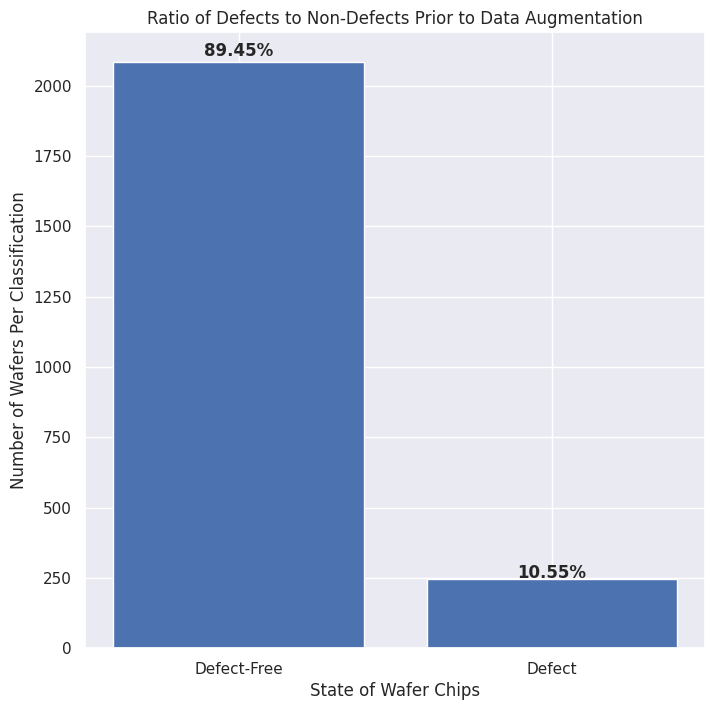

In [5]:
count_true = 0
count_false = 0

for t in firm_labels_images:
    if t[1] == False:
        count_false += 1
    elif t[1] == True:
        count_true += 1

percentage_true = round(count_true/(count_true + count_false)*100, 2)
percentage_false = round(count_false/(count_true + count_false)*100, 2)

df = pd.DataFrame(data={"Classification": ["Defect-Free", "Defect"],
                        "Count": [count_true, count_false],
                        "Percentage": [percentage_true, percentage_false]})

# depict illustration
plt.figure(figsize=(8,8))
graph = plt.bar(df.Classification, df.Count)
plt.xlabel("State of Wafer Chips")
plt.ylabel("Number of Wafers Per Classification")
plt.title("Ratio of Defects to Non-Defects Prior to Data Augmentation")

# Adding percentage to each bar graph
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(df.Percentage[i])+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

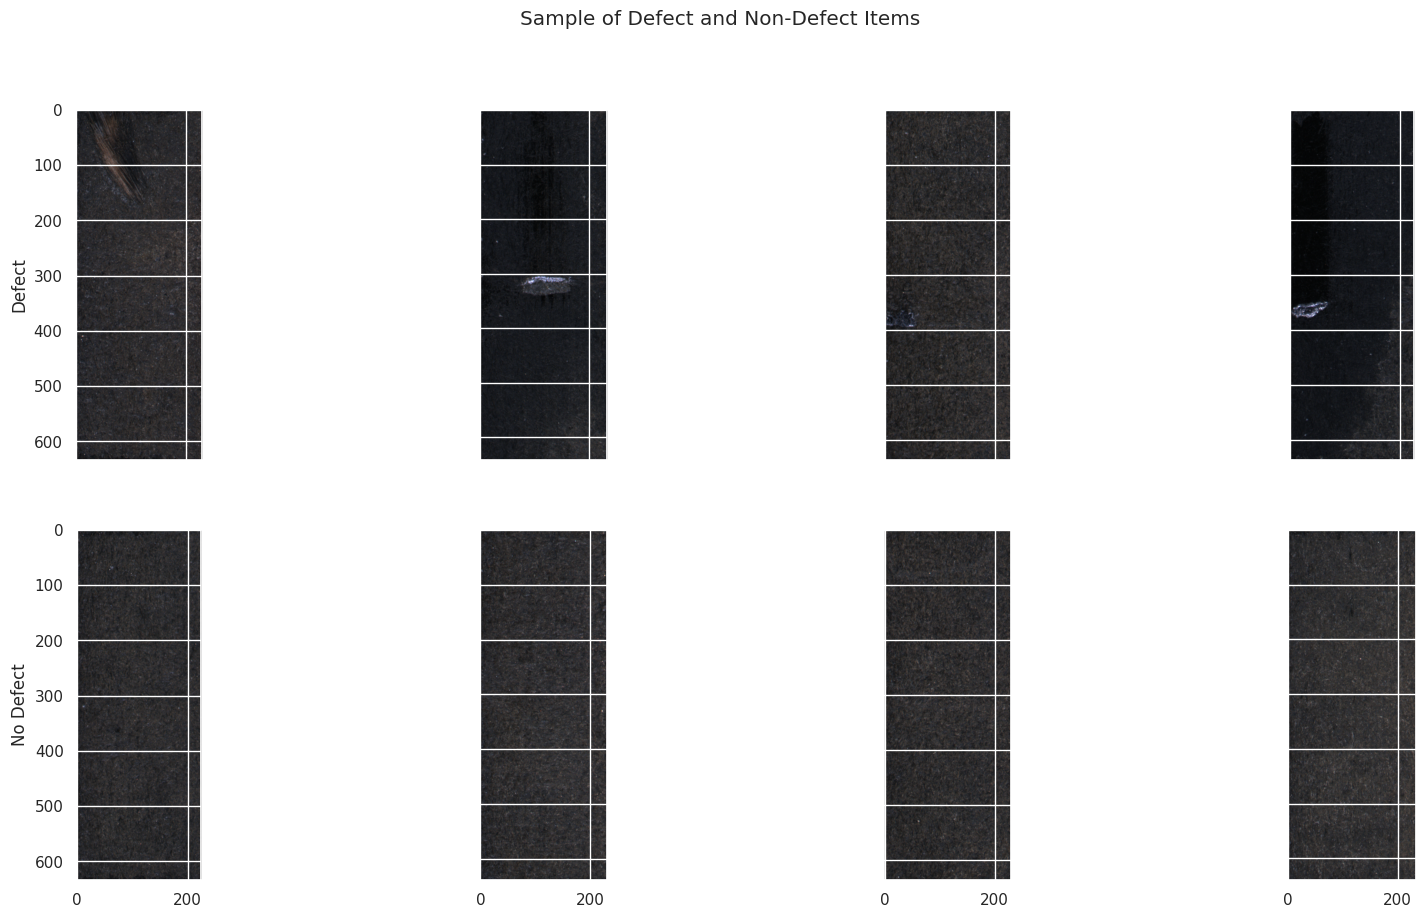

In [6]:
# Image Inspection
indx=0
sample_images = []

counter = 0
for t in firm_labels_images:
  # False means wafer is defected
  if t[1] == False and counter < 4:
    img_number = t[0]
    img = load_img(f"{TRAIN_DIRECTORY}{img_number}.png")
    sample_images.append(img)
    counter+=1
  else:
    continue

counter = 0
for t in firm_labels_images:
  # False means wafer is defected
  if t[1] == True and counter < 4:
    img_number = t[0]
    img = load_img(f"{TRAIN_DIRECTORY}{img_number}.png")
    sample_images.append(img)
    counter+=1
  else:
    continue


nrows, ncols = 2, 4 #print first 8 images
fig, axs = plt.subplots(nrows, ncols, figsize=(20,10))
fig.suptitle('Sample of Defect and Non-Defect Items')
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].imshow(sample_images[indx])
        indx += 1

axs[0, 0].set_ylabel("Defect")
axs[0, 1].set_ylabel("Defect")
axs[0, 2].set_ylabel("Defect")
axs[0, 3].set_ylabel("Defect")
axs[1, 0].set_ylabel("No Defect")
axs[1, 1].set_ylabel("No Defect")
axs[1, 2].set_ylabel("No Defect")
axs[1, 3].set_ylabel("No Defect")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Principal Component Analysis for Image Compression

In [185]:
# Take a sample image and view its dimensions
image_raw = imread(f"{TRAIN_DIRECTORY}11432.png")
print(image_raw.shape)

(640, 231, 3)


In [186]:
# Sum the RGB channel values for each pixel
image_sum = image_raw.sum(axis=2)
print(image_sum.shape)

(640, 231)


In [187]:
# Cap values to 1
image_bw = image_sum/image_sum.max()
print(image_bw.max())

1.0


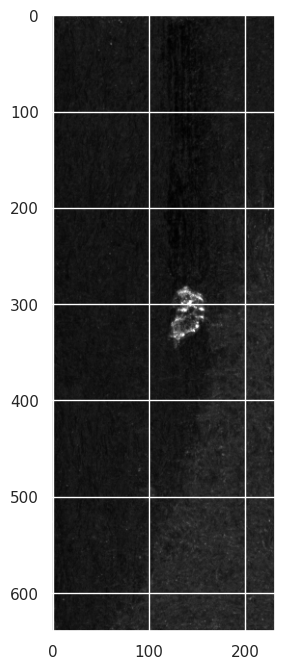

In [188]:
# Plot the image in grayscale
plt.figure(figsize=[12,8])
plt.imshow(image_bw, cmap=plt.cm.gray)

In [189]:
# Perform PCA on the image
pca = PCA()
pca.fit(image_bw)

PCA()

In [190]:
# Getting the cumulative variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))

Number of components explaining 95% variance: 66


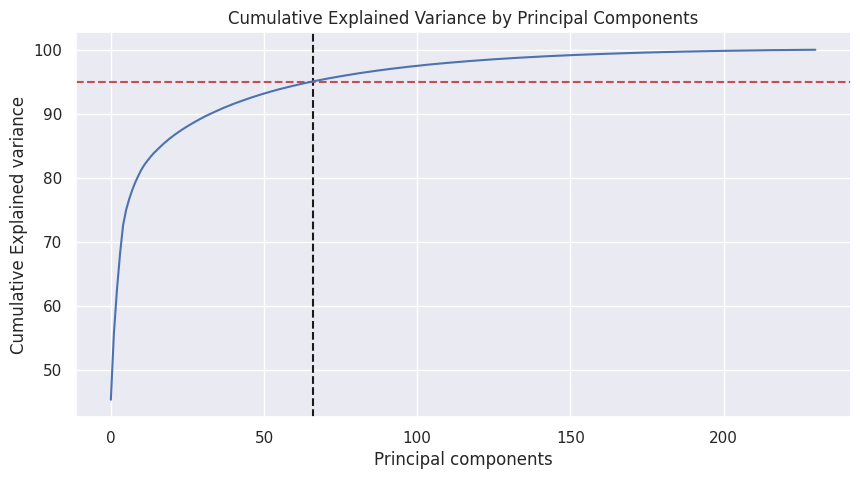

In [191]:
plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance by Principal Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

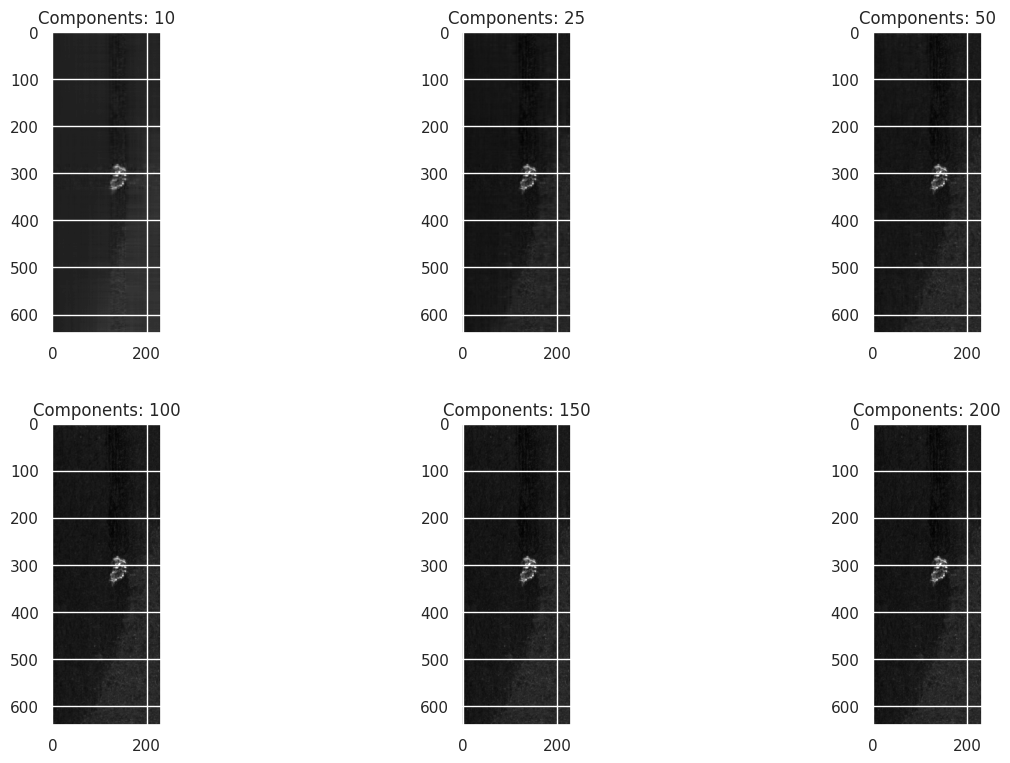

In [192]:
# Function to reconstruct and plot image for a given number of components

def plot_at_k(k):
    ipca = IncrementalPCA(n_components=k)
    image_recon = ipca.inverse_transform(ipca.fit_transform(image_bw))
    plt.imshow(image_recon, cmap = plt.cm.gray)


ks = [10, 25, 50, 100, 150, 200]

plt.figure(figsize=[15,9])

for i in range(6):
  plt.subplot(2,3,i+1)
  plot_at_k(ks[i])
  plt.title("Components: "+str(ks[i]))

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

In [15]:
# Helper Function to compress all images

def compress_image(image_file_dir, k_components):

  image_raw = imread(f"{image_file_dir}")
  image_sum = image_raw.sum(axis=2)
  image_bw = image_sum/image_sum.max()
  ipca = IncrementalPCA(n_components=k_components)
  image_recon = ipca.inverse_transform(ipca.fit_transform(image_bw))

  return image_recon

In [16]:
# Compress All Images

def compress_all_images():

  if os.path.isdir(COMPRESSED_IMAGES):
    print("Directory exists. Proceed to use the images here.")
  else:
    print("Directory does not exists. Make the directory")
    os.mkdir(path=COMPRESSED_IMAGES)

    # Proceed to compress all images
    print("Compressing all images using PCA...")
    for image_file in firm_labels_images:

      image_file_number = image_file[0]

      compressed_image = compress_image(image_file_dir=f"{TRAIN_DIRECTORY}{image_file_number}.png",
                                        k_components=125)

      cv2.imwrite(f"{COMPRESSED_IMAGES}{image_file_number}.png",
                  compressed_image)

    print("Completed image compression using PCA.")

  return None

In [17]:
compress_all_images()

Directory does not exists. Make the directory
Compressing all images using PCA...
Completed image compression using PCA.


### Load Data Helper Function

In [18]:
def load_data(ml_algo=None):

  """Function to load the data for specific types of machine learning
  algorithms and processes"""

  x_train_list = []
  y_train_list = []

  if ml_algo in ["Logistic Regression",
                 "Naive-Bayes",
                 "K-Nearest-Neighbors",
                 "Gradient-Boosting",
                 "Random-Forest",
                 "Decision-Tree",
                 "SVM"]:

    for image_file in firm_labels_images:

      image_file_number = image_file[0]
      image_label = image_file[1]

      if image_label == True:
        image_label_binary = float(1)
      elif image_label == False:
        image_label_binary = float(0)

      # Load the images and convert them to arrays
      image_arr = cv2.imread(f"{COMPRESSED_IMAGES}{image_file_number}.png")
      image_arr_resized = cv2.resize(image_arr, (230, 630))

      x_train_list.append(image_arr_resized[:,0,0])
      y_train_list.append(image_label_binary)

    x_train_array = np.asarray(x_train_list)
    y_train_array = np.asarray(a=y_train_list, dtype=np.float32)

    return x_train_array, y_train_array

  elif ml_algo == "Find-K":

    for image_file in firm_labels_images:

      image_file_number = image_file[0]
      image_label = image_file[1]

      if image_label == True:
        image_label_binary = float(1)
      elif image_label == False:
        image_label_binary = float(0)

      # Load the images and convert them to arrays
      image_arr = cv2.imread(f"{COMPRESSED_IMAGES}{image_file_number}.png")
      image_arr_resized = cv2.resize(image_arr, (230, 630))

      x_train_list.append(image_arr_resized[0,0,0])
      y_train_list.append(image_label_binary)

    x_train_array = np.asarray(x_train_list)
    y_train_array = np.asarray(y_train_list)

    return x_train_array, y_train_array

  elif ml_algo in ["cnn", "resnet"]:

    for image_file in firm_labels_images:

      image_file_number = image_file[0]
      image_label = image_file[1]

      if image_label == True:
        y_train_list.append(float(1))
      elif image_label == False:
        y_train_list.append(float(0))
      else:
        continue

      # Trial runs
      img = load_img(
          f"{COMPRESSED_IMAGES}{image_file_number}.png",
          target_size=(224, 224))

      # transform image to array
      img = img_to_array(img)

      # append to list of images
      x_train_list.append(img)

    # Stack images and trans
    x_train_array = np.stack(x_train_list)
    y_train_array = np.asarray(a=y_train_list, dtype=np.float32).flatten()

    return x_train_array, y_train_array

  elif ml_algo == "xception":

    for image_file in firm_labels_images:

      image_file_number = image_file[0]
      image_label = image_file[1]

      if image_label == True:
        y_train_list.append(1)
      elif image_label == False:
        y_train_list.append(0)
      else:
        continue

      # Trial runs
      img = load_img(
        f"{COMPRESSED_IMAGES}{image_file_number}.png",
        target_size=(299, 299))

      # transform image to array
      img = img_to_array(img)

      # append to list of images
      x_train_list.append(img)

    # Stack images and trans
    x_train_array = np.stack(x_train_list)
    y_train_array = np.array(y_train_list).flatten()

    return x_train_array, y_train_array

  else:
    return None

### 1. Logistic Regression

In [19]:
def log_loss(Y_true, Y_pred):
  """Returns the binary log loss for a list of labels and predictions.

  Args:
    Y_true: A list of (true) labels (0 or 1)
    Y_pred: A list of corresponding predicted probabilities

  Returns:
    Binary log loss
  """
  # YOUR CODE HERE
  outer_sum = []

  for y_i in range(len(Y_true)):

    # Calculate y_i*log(y_hat_i)
    left_hand_side = (Y_true[y_i])*(np.log(Y_pred[y_i]))
    # Calculate (1-y_i)*log(1-y_hat_i)
    right_hand_side = (1-(Y_true[y_i]))*(np.log( 1 - (Y_pred[y_i])))
    sum_both = left_hand_side + right_hand_side
    outer_sum.append(sum_both)

  absolute_value_y = -abs(len(Y_true))
  sigma_sum = sum(outer_sum)

  loss = (1/absolute_value_y)*(sigma_sum)

  return loss

In [20]:
# Logistic Regression Model
def logistic_regression_build_model(learning_rate=0.01):
  """Build a TF logistic regression model using Keras.

  Args:
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # Build a model using keras.Sequential.
  model = keras.Sequential()

  # Keras layers can do pre-processing. This layer will take our 28x28 images
  # and flatten them into vectors of size 784.
  model.add(keras.layers.Flatten())

  # This layer constructs the linear set of parameters for each input feature
  # (as well as a bias), and applies a sigmoid to the result. The result is
  # binary logistic regression.
  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="sigmoid"         # apply the sigmoid function!
  ))

  # Use the SGD optimizer as usual.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # We specify the binary_crossentropy loss (equivalent to log loss).
  # Notice that we are including 'binary accuracy' as one of the metrics that we
  # ask Tensorflow to report when evaluating the model.
  model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=[keras_metrics.binary_accuracy,
                         keras_metrics.Precision(),
                         keras_metrics.Recall(),
                         keras_metrics.AUC(),
                         keras_metrics.F1Score(threshold=0.5)])

  return model

In [21]:
label_names = ["Defect", "No-Defect"]

#### No Data Augmentation

In [234]:
(X_train, y_train) = load_data(ml_algo="Logistic Regression")

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print("Total Counts of Defects and Non-Defects in dataset")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print("Counts of Defects and Non-Defects in dataset after Train/Test split")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

X_train shape (2331, 630)
y_train shape (2331,)

Total Counts of Defects and Non-Defects in dataset
True count: 2085
False count: 246
Total counts: 2331

Counts of Defects and Non-Defects in dataset after Train/Test split
True count: 1565
False count: 183
Total counts: 1748


In [235]:
# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = y_train.flatten()
Y_test = y_test.flatten()

# Pixel values range from 0 to 255. To normalize the data,
# we just need to divide all values by 255.
X_train = X_train / 255
X_test = X_test / 255

# Make copies of the original dataset for binary classification task.
X_train_binary = np.copy(X_train)
X_test_binary = np.copy(X_test)
Y_train_binary = np.copy(Y_train)
Y_test_binary = np.copy(Y_test)

# Data Shuffling

np.random.seed(0) # For reproducibility

indices = np.arange(X_train_binary.shape[0])
shuffled_indices = np.random.permutation(indices)

# Re-order training examples and corresponding labels using the randomly
# shuffled indices.
X_train_binary = X_train_binary[shuffled_indices]
Y_train_binary = Y_train_binary[shuffled_indices]


print("Number of non-defect images in training set: %d"%(Y_train_binary == 1).sum())
print("Number of defect images in training set: %d"%(Y_train_binary == 0).sum())

Number of non-defect images in training set: 1565
Number of defect images in training set: 183


In [236]:
# Computing the baseline using 0.1 as the predicted probability
baseline = np.full(Y_train_binary.size, 0.1)


print(f"Log Loss of Training Data: {log_loss(Y_train_binary, baseline)}")
print(f"Log Loss of Test Data: {log_loss(Y_test_binary, baseline)}")

Log Loss of Training Data: 2.0725552888449896
Log Loss of Test Data: 2.065149160966297


In [237]:
# Build the model.
model_no_data_augmentation = logistic_regression_build_model()

# Make a prediction for five inputs.
print(model_no_data_augmentation.predict(X_train_binary[0:5]))

1/1 [==============================] - 0s 80ms/step
[[0.5       ]
 [0.5       ]
 [0.50011045]
 [0.5       ]
 [0.5       ]]


In [240]:
model_no_data_augmentation = logistic_regression_build_model(learning_rate=0.01)

# Fit the model.
history = model_no_data_augmentation.fit(
  x = X_train_binary,   # our binary training examples
  y = Y_train_binary,   # corresponding binary labels
  epochs=10,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history_df = pd.DataFrame(history.history)
display(history_df)

Epoch 1/10
25/25 [==============================] - 1s 19ms/step - loss: 0.6755 - binary_accuracy: 0.8697 - precision: 0.8964 - recall: 0.9659 - auc: 0.5024 - f1_score: 0.9299 - val_loss: 0.6558 - val_binary_accuracy: 0.9029 - val_precision: 0.9029 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1_score: 0.9489
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6410 - binary_accuracy: 0.8945 - precision: 0.8945 - recall: 1.0000 - auc: 0.4811 - f1_score: 0.9443 - val_loss: 0.6228 - val_binary_accuracy: 0.9029 - val_precision: 0.9029 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1_score: 0.9489
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6106 - binary_accuracy: 0.8945 - precision: 0.8945 - recall: 1.0000 - auc: 0.4930 - f1_score: 0.9443 - val_loss: 0.5935 - val_binary_accuracy: 0.9029 - val_precision: 0.9029 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1_score: 0.9489
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - los

,loss,binary_accuracy,precision,recall,auc,f1_score,val_loss,val_binary_accuracy,val_precision,val_recall,val_auc,val_f1_score
0,0.675492,0.869676,0.896438,0.965885,0.502376,[0.9298666],0.655774,0.902857,0.902857,1.0,0.5,[0.948949]
1,0.640999,0.894469,0.894469,1.000000,0.481123,[0.9442953],0.622799,0.902857,0.902857,1.0,0.5,[0.948949]
2,0.610584,0.894469,0.894469,1.000000,0.493015,[0.9442953],0.593460,0.902857,0.902857,1.0,0.5,[0.948949]
3,0.583556,0.894469,0.894469,1.000000,0.489052,[0.9442953],0.567513,0.902857,0.902857,1.0,0.5,[0.948949]
4,0.559672,0.894469,0.894469,1.000000,0.504331,[0.9442953],0.544461,0.902857,0.902857,1.0,0.5,[0.948949]
5,0.538474,0.894469,0.894469,1.000000,0.486119,[0.9442953],0.524142,0.902857,0.902857,1.0,0.5,[0.948949]
6,0.519804,0.894469,0.894469,1.000000,0.492396,[0.9442953],0.506042,0.902857,0.902857,1.0,0.5,[0.948949]
7,0.503183,0.894469,0.894469,1.000000,0.503243,[0.9442953],0.489885,0.902857,0.902857,1.0,0.5,[0.948949]
8,0.488360,0.894469,0.894469,1.000000,0.500208,[0.9442953],0.475300,0.902857,0.902857,1.0,0.5,[0.948949]
9,0.474990,0.894469,0.894469,1.000000,0.522658,[0.9442953],0.462228,0.902857,0.902857,1.0,0.5,[0.948949]


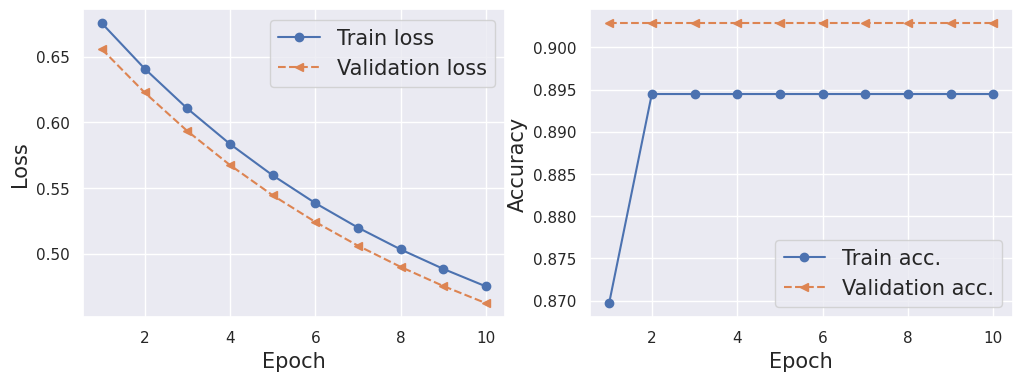

In [241]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['binary_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_binary_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [27]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions. Note that these are the predicted probabilities of the
# positive class.
# test_predictions_no_augmentation = model_no_data_augmentation.predict(X_test_binary).flatten()
# print(test_predictions_no_augmentation.shape)
# print(test_predictions_no_augmentation)

In [200]:
# The model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions_no_augmentation = np.argmax(model_no_data_augmentation.predict(X_test_binary), axis=-1)
print(test_predictions_no_augmentation)

19/19 [==============================] - 0s 1ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [201]:
# Create a set of binary results for predictions above 0.5
THRESHOLD = 0.5
y_test_pred_outcome = np.where(test_predictions_no_augmentation>=THRESHOLD, 1, 0)

# Denominator denotes the incorrect results.
number_of_errors = (Y_test_binary != y_test_pred_outcome).sum()

# Numerator is the total number of predictions
total_number_of_predictions = len(test_predictions_no_augmentation)

# This gives an error rate.
error_test_accuracy = (number_of_errors)/total_number_of_predictions

# The complement of the error test accuracy is the prediction accuracy.
print(f"Test data prediction accuracy using a 0.5 threshold: {1-error_test_accuracy: .3f}")


Test data prediction accuracy using a 0.5 threshold:  0.093


In [202]:
# The model includes 2 layers: a flattening layer and a dense layer.
print(model_no_data_augmentation.layers)

# Retrieve the weights and biases from the dense layer.
weights, biases = model_no_data_augmentation.layers[1].get_weights()
bias = biases[0]  # there's only 1 bias
weights = weights.flatten()  # flatten the weights to a vector
print('Bias:', bias)
print('Weights shape:', weights.shape)

[<keras.src.layers.reshaping.flatten.Flatten object at 0x7a8db7c9f880>, <keras.src.layers.core.dense.Dense object at 0x7a8db7097be0>]
Bias: 0.7395377
Weights shape: (630,)


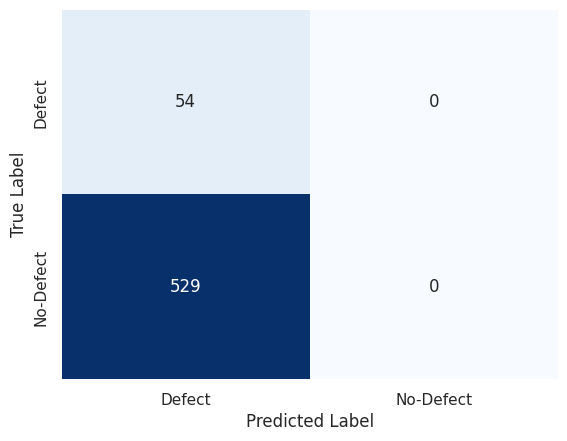

In [203]:
# Create a confusion matrix as a 2D array.
confusion_matrix_no_augmentation = tf.math.confusion_matrix(Y_test_binary,
                                                            test_predictions_no_augmentation,
                                                            num_classes=2)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix_no_augmentation,
                 annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [211]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train_binary, Y_train_binary)

y_pred = clf.predict(X_test_binary)

accuracy = sklearn_metrics.accuracy_score(Y_test_binary, y_pred)
precision = sklearn_metrics.precision_score(Y_test_binary, y_pred)
recall = sklearn_metrics.recall_score(Y_test_binary, y_pred)
f1_score = sklearn_metrics.f1_score(Y_test_binary, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1_score)

Test Accuracy: 0.8833619210977701
Test Precision: 0.8833619210977701
Test Recall: 1.0
Test F1 Score: 0.9380692167577414


#### Data Augmentation

In [32]:
label_names = ["Defect", "No-Defect"]

In [242]:
(X_train, y_train) = load_data(ml_algo="Logistic Regression")

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print("Total Counts of Defects and Non-Defects in dataset")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print("Counts of Defects and Non-Defects in dataset after Train/Test split")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

# Data Augmentation
smote_augmentation = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote_augmentation.fit_resample(X_train, y_train)

count_true = 0
count_false = 0

for t in y_train_smote:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print(f"X_train_smote shape {X_train_smote.shape}")
print(f"Y_train_smote shape {y_train_smote.shape}")
print("Counts of Defects and Non-Defects with SMOTE augmentation")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

X_train shape (2331, 630)
y_train shape (2331,)

Total Counts of Defects and Non-Defects in dataset
True count: 2085
False count: 246
Total counts: 2331

Counts of Defects and Non-Defects in dataset after Train/Test split
True count: 1548
False count: 200
Total counts: 1748

X_train_smote shape (3096, 630)
Y_train_smote shape (3096,)
Counts of Defects and Non-Defects with SMOTE augmentation
True count: 1548
False count: 1548
Total counts: 3096


In [243]:
# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train_smote = y_train_smote.flatten()
Y_test = y_test.flatten()

# Pixel values range from 0 to 255. To normalize the data,
# we just need to divide all values by 255.
X_train_smote = X_train_smote / 255
X_test = X_test / 255

# Make copies of the original dataset for binary classification task.
X_train_binary_smote = np.copy(X_train_smote)
X_test_binary = np.copy(X_test)
Y_train_binary_smote = np.copy(Y_train_smote)
Y_test_binary = np.copy(Y_test)

# Data Shuffling

np.random.seed(0) # For reproducibility

indices = np.arange(X_train_binary_smote.shape[0])
shuffled_indices = np.random.permutation(indices)

# Re-order training examples and corresponding labels using the randomly
# shuffled indices.
X_train_binary_smote = X_train_binary_smote[shuffled_indices]
Y_train_binary_smote = Y_train_binary_smote[shuffled_indices]


print("Number of non-defect images in training set: %d"%(Y_train_binary_smote == 1).sum())
print("Number of defect images in training set: %d"%(Y_train_binary_smote == 0).sum())

Number of non-defect images in training set: 1548
Number of defect images in training set: 1548


In [244]:
# Computing the baseline using 0.1 as the predicted probability
baseline = np.full(Y_train_binary_smote.size, 0.1)


print(f"Log Loss of Training Data: {log_loss(Y_train_binary_smote, baseline)}")
print(f"Log Loss of Test Data: {log_loss(Y_test_binary, baseline)}")

Log Loss of Training Data: 1.2039728043259716
Log Loss of Test Data: 2.129219174370615


In [245]:
# Build the model.
model_with_data_augmentation = logistic_regression_build_model()

# Make a prediction for five inputs.
print(model_with_data_augmentation.predict(X_train_binary_smote[0:5]))

1/1 [==============================] - 0s 74ms/step
[[0.5       ]
 [0.5000717 ]
 [0.5       ]
 [0.5       ]
 [0.50004846]]


In [246]:
# Train the model
model_with_data_augmentation = logistic_regression_build_model(learning_rate=0.01)

# Fit the model.
history = model_with_data_augmentation.fit(
  x = X_train_binary_smote,   # our binary training examples
  y = Y_train_binary_smote,   # corresponding binary labels
  epochs=10,                   # number of passes through the training data
  batch_size=64,              # mini-batch size for SGD
  validation_split=0.1,       # use a fraction of the examples for validation
  verbose=1                   # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history_df = pd.DataFrame(history.history)
display(history_df)

Epoch 1/10
44/44 [==============================] - 1s 12ms/step - loss: 0.6938 - binary_accuracy: 0.5251 - precision: 0.5169 - recall: 0.9532 - auc: 0.4636 - f1_score: 0.6703 - val_loss: 0.6938 - val_binary_accuracy: 0.4774 - val_precision: 0.4582 - val_recall: 1.0000 - val_auc: 0.4798 - val_f1_score: 0.6284
Epoch 2/10
44/44 [==============================] - 0s 4ms/step - loss: 0.6938 - binary_accuracy: 0.5319 - precision: 0.5197 - recall: 1.0000 - auc: 0.4607 - f1_score: 0.6840 - val_loss: 0.6939 - val_binary_accuracy: 0.4774 - val_precision: 0.4582 - val_recall: 1.0000 - val_auc: 0.4740 - val_f1_score: 0.6284
Epoch 3/10
44/44 [==============================] - 0s 4ms/step - loss: 0.6938 - binary_accuracy: 0.5309 - precision: 0.5191 - recall: 1.0000 - auc: 0.4582 - f1_score: 0.6835 - val_loss: 0.6940 - val_binary_accuracy: 0.4774 - val_precision: 0.4582 - val_recall: 1.0000 - val_auc: 0.4595 - val_f1_score: 0.6284
Epoch 4/10
44/44 [==============================] - 0s 4ms/step - los

,loss,binary_accuracy,precision,recall,auc,f1_score,val_loss,val_binary_accuracy,val_precision,val_recall,val_auc,val_f1_score
0,0.693839,0.525126,0.516910,0.953225,0.463636,[0.67032146],0.693848,0.477419,0.458194,1.0,0.479769,[0.6284404]
1,0.693794,0.531945,0.519705,1.000000,0.460727,[0.68395543],0.693940,0.477419,0.458194,1.0,0.473988,[0.6284404]
2,0.693753,0.530869,0.519132,1.000000,0.458182,[0.6834585],0.694031,0.477419,0.458194,1.0,0.459538,[0.6284404]
3,0.693718,0.527997,0.517608,1.000000,0.454752,[0.68213683],0.694116,0.477419,0.458194,1.0,0.459960,[0.6284404]
4,0.693669,0.528715,0.517988,1.000000,0.463950,[0.6824668],0.694186,0.477419,0.458194,1.0,0.508249,[0.6284404]
5,0.693629,0.525844,0.516471,1.000000,0.493779,[0.68114895],0.694229,0.477419,0.458194,1.0,0.505780,[0.6284404]
6,0.693598,0.526561,0.516850,1.000000,0.496456,[0.6814779],0.694283,0.474194,0.456667,1.0,0.505780,[0.6270023]
7,0.693559,0.528715,0.517988,1.000000,0.480093,[0.6824668],0.694321,0.470968,0.455150,1.0,0.502890,[0.6255708]
8,0.693518,0.526920,0.517039,1.000000,0.493455,[0.6816425],0.694344,0.470968,0.455150,1.0,0.505780,[0.6255708]
9,0.693489,0.527279,0.517229,1.000000,0.491636,[0.68180716],0.694376,0.467742,0.453642,1.0,0.505780,[0.6241458]


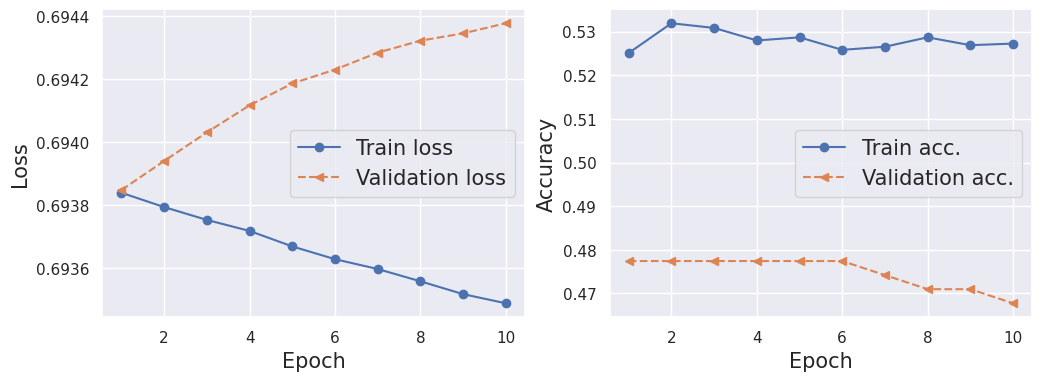

In [247]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['binary_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_binary_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [38]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions. Note that these are the predicted probabilities of the
# positive class.
# test_predictions_with_augmentation = model_with_data_augmentation.predict(X_test_binary).flatten()
# print(test_predictions_with_augmentation.shape)
# print(test_predictions_with_augmentation)

In [39]:
# The model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions_with_augmentation = np.argmax(model_with_data_augmentation.predict(X_test_binary), axis=-1)
print(test_predictions_with_augmentation)

19/19 [==============================] - 0s 1ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [40]:
# Create a set of binary results for predictions above 0.5
THRESHOLD = 0.5
y_test_pred_outcome = np.where(test_predictions_with_augmentation>=THRESHOLD, 1, 0)

# Denominator denotes the incorrect results.
number_of_errors = (Y_test_binary != y_test_pred_outcome).sum()

# Numerator is the total number of predictions
total_number_of_predictions = len(test_predictions_with_augmentation)

# This gives an error rate.
error_test_accuracy = (number_of_errors)/total_number_of_predictions

# The complement of the error test accuracy is the prediction accuracy.
print(f"Test data prediction accuracy using a 0.5 threshold: {1-error_test_accuracy: .3f}")


Test data prediction accuracy using a 0.5 threshold:  0.079


In [41]:
# The model includes 2 layers: a flattening layer and a dense layer.
print(model_with_data_augmentation.layers)

# Retrieve the weights and biases from the dense layer.
weights, biases = model_with_data_augmentation.layers[1].get_weights()
bias = biases[0]  # there's only 1 bias
weights = weights.flatten()  # flatten the weights to a vector
print('Bias:', bias)
print('Weights shape:', weights.shape)

[<keras.src.layers.reshaping.flatten.Flatten object at 0x7a8f1c3a6f80>, <keras.src.layers.core.dense.Dense object at 0x7a8f1c3d15a0>]
Bias: 0.01647559
Weights shape: (630,)


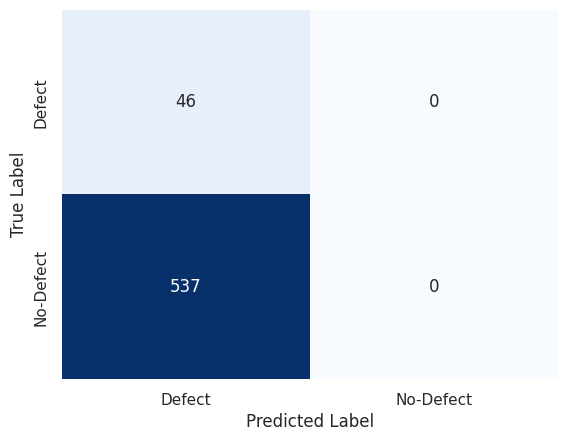

In [42]:
# Create a confusion matrix as a 2D array.
confusion_matrix_with_augmentation = tf.math.confusion_matrix(Y_test_binary,
                                                              test_predictions_with_augmentation)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix_with_augmentation,
                 annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [223]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train_binary_smote,
                                             Y_train_binary_smote)

y_pred = clf.predict(X_test_binary)

accuracy = sklearn_metrics.accuracy_score(Y_test_binary, y_pred)
precision = sklearn_metrics.precision_score(Y_test_binary, y_pred)
recall = sklearn_metrics.recall_score(Y_test_binary, y_pred)
f1_score = sklearn_metrics.f1_score(Y_test_binary, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1_score)

Test Accuracy: 0.8919382504288165
Test Precision: 0.8919382504288165
Test Recall: 1.0
Test F1 Score: 0.942883046237534


### 2. Decision Trees

#### No Data Augmentation

In [ ]:
#(X_train, y_train) = load_data(ml_algo="Naive-Bayes")
(X_train, y_train) = load_data(ml_algo="Decision-Tree")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

In [ ]:
model = DecisionTreeClassifier()
estimator = model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
test_accuracy = print(sklearn_metrics.accuracy_score(y_test, y_pred)*100)
train_accuracy = print(sklearn_metrics.accuracy_score(y_train, y_pred_train)*100)

In [ ]:
# Display confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [ ]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", recall)

#### Data Augmentation

In [42]:
#(X_train, y_train) = load_data(ml_algo="Naive-Bayes")
(X_train, y_train) = load_data(ml_algo="Decision-Tree")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

In [ ]:
# Data Augmentation
smote_augmentation = SMOTE(sampling_strategy="auto", random_state=42)

X_train_smote, Y_train_smote = smote_augmentation.fit_resample(X_train, y_train)

In [ ]:
print("X_train_smote.shape:", X_train_smote.shape)
print("Y_train_smote.shape:", Y_train_smote.shape)

In [ ]:
count_true = 0
count_false = 0

for t in Y_train_smote:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

In [ ]:
model = DecisionTreeClassifier()
estimator = model.fit(X_train_smote, Y_train_smote)

In [ ]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
test_accuracy = print(sklearn_metrics.accuracy_score(y_test, y_pred)*100)
train_accuracy = print(sklearn_metrics.accuracy_score(y_train, y_pred_train)*100)

In [ ]:
# Display confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [ ]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", recall)

### 3. Random Forest

#### No Data Augmentation

In [ ]:
#(X_train, y_train) = load_data(ml_algo="Naive-Bayes")
(X_train, y_train) = load_data(ml_algo="Random-Forest")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

In [ ]:
model = RandomForestClassifier()
estimator = model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
test_accuracy = print(sklearn_metrics.accuracy_score(y_test, y_pred)*100)
train_accuracy = print(sklearn_metrics.accuracy_score(y_train, y_pred_train)*100)

In [ ]:
# Display confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [ ]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", recall)

#### Data Augmentation

In [42]:
#(X_train, y_train) = load_data(ml_algo="Naive-Bayes")
(X_train, y_train) = load_data(ml_algo="Random-Forest")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

In [ ]:
# Data Augmentation
smote_augmentation = SMOTE(sampling_strategy="auto", random_state=42)

X_train_smote, Y_train_smote = smote_augmentation.fit_resample(X_train, y_train)

In [ ]:
print("X_train_smote.shape:", X_train_smote.shape)
print("Y_train_smote.shape:", Y_train_smote.shape)

In [ ]:
count_true = 0
count_false = 0

for t in Y_train_smote:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

In [ ]:
model = RandomForestClassifier()
estimator = model.fit(X_train_smote, Y_train_smote)

In [ ]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
test_accuracy = print(sklearn_metrics.accuracy_score(y_test, y_pred)*100)
train_accuracy = print(sklearn_metrics.accuracy_score(y_train, y_pred_train)*100)

In [ ]:
# Display confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [ ]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", recall)

### 4. K-Nearest Neighbor

#### No Data Augmentation

In [45]:
(X_train, y_train) = load_data(ml_algo="Find-K")

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print("Total Counts of Defects and Non-Defects in dataset")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print("Counts of Defects and Non-Defects in dataset after Train/Test split")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

X_train shape (2331,)
y_train shape (2331,)

Total Counts of Defects and Non-Defects in dataset
True count: 2085
False count: 246
Total counts: 2331

Counts of Defects and Non-Defects in dataset after Train/Test split
True count: 1558
False count: 190
Total counts: 1748


In [46]:
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)

In [47]:
# calculate euclidean distance
def dist(x,y):
    return np.sqrt(np.sum((x-y)**2))

In [48]:
train_index_upper_bound = df_train.shape[0]

# a list to store euclidean distance
train_distance_list = []
# a list to store index
train_ind_counter = []
# a list with all the K values
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19,21]
# creating a list of list for storing the predictions for each value of K
train_pred_lists = [[] for _ in range(len(k_values))]


# training the knn model
# iterating through the training set
for i in range(0, train_index_upper_bound):
    train_vec_one = df_train.iloc[i]
    # iterating through the training set
    for j in range(0, train_index_upper_bound):
        train_vec = df_train.iloc[j]
        # calculate euclidean distance by calling function dist
        euclidean_dist = dist(train_vec_one,train_vec)
        train_distance_list.append(euclidean_dist)
        # increment the index
        train_ind_counter.append(j)

    # dictionary to store all the results
    d = {'index':train_ind_counter, 'distance': train_distance_list}
    # convert dictionary to dataframe
    df = pd.DataFrame(d, columns = ['index', 'distance'])
    # sort in ascending order by euclidean distance
    df_sorted = df.sort_values(by = 'distance')

    # iterate through each value of K
    for K in range(len(k_values)):
        index_list = list(df_sorted['index'][:k_values[K]])
        distance = list(df_sorted['distance'][:k_values[K]])
        res_list = [y_train[i] for i in index_list]
        # now get the count of the max class in result list
        pred_value = max(res_list,key=res_list.count)
        # storing every prediction for K in respective list
        train_pred_lists[K].append(pred_value)

    # reinitialize the list
    train_ind_counter = []
    train_distance_list = []

In [49]:
test_index_upper_bound = df_test.shape[0]

# a list to store euclidean distance
test_distance_list = []
# a list to store index
test_ind_counter = []
# creating a list of list for storing the predictions for each value of K
test_pred_lists = [[] for _ in range(len(k_values))]

# testing the knn model
# iterating through the test set
for i in range(0, test_index_upper_bound):
    test_vec = df_test.iloc[i]
    # iterating through the training set
    for j in range(0, train_index_upper_bound):
        train_vec = df_train.iloc[j]
        # calculate euclidean distance
        euclidean_dist = dist(test_vec,train_vec)
        test_distance_list.append(euclidean_dist)
        # increment the index
        test_ind_counter.append(j)

    # dictionary to store all the results
    d = {'index':test_ind_counter, 'distance': test_distance_list}
    # convert dictionary to dataframe
    df = pd.DataFrame(d, columns = ['index', 'distance'])
    # sort in ascending order by euclidean distance
    df_sorted = df.sort_values(by = 'distance')

    # iterate through each value of K
    for K in range(len(k_values)):
        index_list = list(df_sorted['index'][:k_values[K]])
        distance = list(df_sorted['distance'][:k_values[K]])
        res_list = [train_pred_lists[K][ind] for ind in index_list]
        # now get the count of the max class in result list
        pred_value = max(res_list,key=res_list.count)
        # storing every prediction in respective list
        test_pred_lists[K].append(pred_value)

    # # reinitialize the list
    test_ind_counter = []
    test_distance_list = []

In [50]:
# calculating results for train set
train_pred = 0
train_pred_result = []
for K in range(len(k_values)):
    # element wise comparison to find the accuracy
    for l1,l2 in zip(train_pred_lists[K], y_train.tolist()):
        if l1 == l2:
            # increment when there is a match
            train_pred += 1
    accuracy = train_pred/6000
    train_pred_result.append((round(accuracy*100,2)))
    print('The train accuracy is '+str(round(accuracy*100,2))+'% for K='+str(k_values[K]))
    train_pred = 0

The train accuracy is 25.97% for K=1
The train accuracy is 25.97% for K=3
The train accuracy is 25.97% for K=5
The train accuracy is 25.97% for K=7
The train accuracy is 25.97% for K=9
The train accuracy is 25.97% for K=11
The train accuracy is 25.97% for K=13
The train accuracy is 25.97% for K=15
The train accuracy is 25.97% for K=17
The train accuracy is 25.97% for K=19
The train accuracy is 25.97% for K=21


In [51]:
# calculating results for test set
test_pred = 0
test_pred_result = []
for K in range(len(k_values)):
    for l1,l2 in zip(test_pred_lists[K], y_test.tolist()):
        if l1 == l2:
            test_pred += 1
    accuracy = test_pred/1000
    test_pred_result.append((round(accuracy*100,2)))
    print('The test accuracy is '+str(accuracy*100)+'% for K='+str(k_values[K]))
    test_pred = 0

The test accuracy is 52.7% for K=1
The test accuracy is 52.7% for K=3
The test accuracy is 52.7% for K=5
The test accuracy is 52.7% for K=7
The test accuracy is 52.7% for K=9
The test accuracy is 52.7% for K=11
The test accuracy is 52.7% for K=13
The test accuracy is 52.7% for K=15
The test accuracy is 52.7% for K=17
The test accuracy is 52.7% for K=19
The test accuracy is 52.7% for K=21


In [52]:
# getting all the results for train and test in a dataframe
df_result = pd.DataFrame()
df_result['K value'] = k_values
df_result['train pred'] = train_pred_result
df_result['test pred'] = test_pred_result
df_result

,K value,train pred,test pred
0,1,25.97,52.7
1,3,25.97,52.7
2,5,25.97,52.7
3,7,25.97,52.7
4,9,25.97,52.7
5,11,25.97,52.7
6,13,25.97,52.7
7,15,25.97,52.7
8,17,25.97,52.7
9,19,25.97,52.7


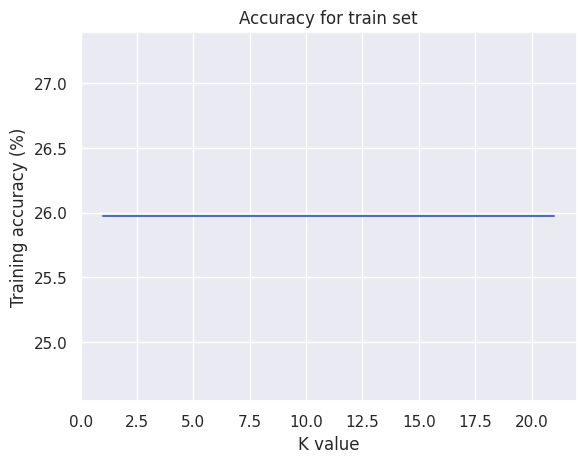

In [53]:
plt.plot(df_result['K value'], df_result['train pred'])
plt.xlabel('K value')
plt.ylabel('Training accuracy (%)')
plt.title('Accuracy for train set')
plt.show()

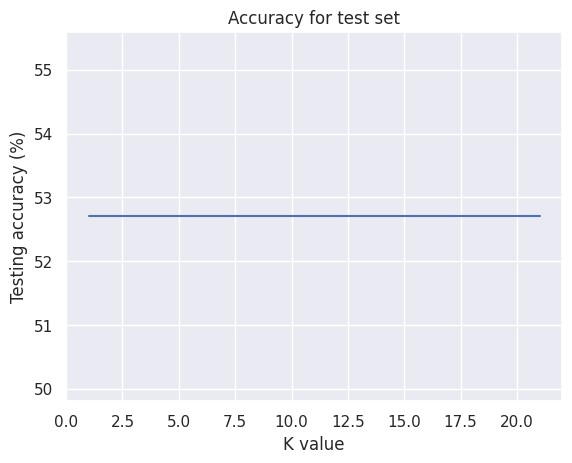

In [54]:
plt.plot(df_result['K value'], df_result['test pred'])
plt.xlabel('K value')
plt.ylabel('Testing accuracy (%)')
plt.title('Accuracy for test set')
plt.show()

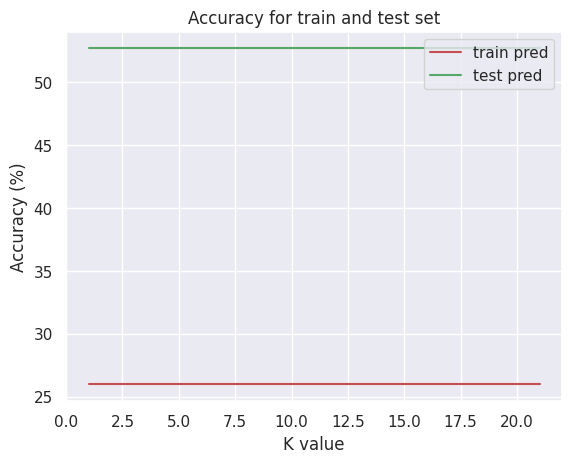

In [55]:
plt.plot(df_result['K value'], df_result['train pred'], 'r', label = 'train pred')
plt.plot(df_result['K value'], df_result['test pred'], 'g', label = 'test pred')
plt.legend(loc='upper right')
plt.xlabel('K value')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for train and test set')
plt.show()

In [56]:
(X_train, y_train) = load_data(ml_algo="K-Nearest-Neighbors")

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print("Total Counts of Defects and Non-Defects in dataset")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

X_train shape (2331, 630)
y_train shape (2331,)

Total Counts of Defects and Non-Defects in dataset
True count: 2085
False count: 246
Total counts: 2331


In [57]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [58]:
y_pred = knn.predict(X_test)

In [59]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1_score)

Test Accuracy: 0.15780445969125215
Test Precision: 0.8888888888888888
Test Recall: 0.06165703275529865
Test F1 Score: 0.1153153153153153


#### Data Augmentation

In [60]:
(X_train, y_train) = load_data(ml_algo="Find-K")

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print("Total Counts of Defects and Non-Defects in dataset")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print("Counts of Defects and Non-Defects in dataset after Train/Test split")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

# Data Augmentation
smote_augmentation = SMOTE(sampling_strategy="auto", random_state=42)

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


X_train_smote, y_train_smote = smote_augmentation.fit_resample(X_train, y_train)

count_true = 0
count_false = 0

for t in y_train_smote:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print(f"X_train_smote shape {X_train_smote.shape}")
print(f"Y_train_smote shape {y_train_smote.shape}")
print("Counts of Defects and Non-Defects with SMOTE augmentation")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

X_train shape (2331,)
y_train shape (2331,)

Total Counts of Defects and Non-Defects in dataset
True count: 2085
False count: 246
Total counts: 2331

Counts of Defects and Non-Defects in dataset after Train/Test split
True count: 1575
False count: 173
Total counts: 1748

X_train_smote shape (3150, 1)
Y_train_smote shape (3150,)
Counts of Defects and Non-Defects with SMOTE augmentation
True count: 1575
False count: 1575
Total counts: 3150


In [61]:
df_train = pd.DataFrame(X_train_smote)
df_test = pd.DataFrame(X_test)

In [62]:
# calculate euclidean distance
def dist(x,y):
    return np.sqrt(np.sum((x-y)**2))

In [63]:
train_index_upper_bound = df_train.shape[0]

# a list to store euclidean distance
train_distance_list = []
# a list to store index
train_ind_counter = []
# a list with all the K values
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19,21]
# creating a list of list for storing the predictions for each value of K
train_pred_lists = [[] for _ in range(len(k_values))]
"""
Each list in your list is a reference to the same object. You modify one, you see the modification in all of them.
https://urldefense.proofpoint.com/v2/url?u=https-3A__stackoverflow.com_questions_8713620_appending-2Ditems-2Dto-2Da-2Dlist-2Dof-2Dlists-2Din-2Dpython-255Cn&d=DwIGAg&c=h2Fu29X6B8vuaRkwP4jdQg&r=VrA8Wg-NQXRIWiLPbMbwreqPxfnbbNHHEdL8LFUK5DI&m=WrZR3go5H-4T0a0mrchaz1zXbxvWsQ_1_g74MZB-6nI&s=A-p1Rw5fxGX587fhSz4ZRl_uAreZ965twblgt5egE_U&e= """


# training the knn model
# iterating through the training set
for i in range(0, train_index_upper_bound):
    train_vec_one = df_train.iloc[i]
    # iterating through the training set
    for j in range(0, train_index_upper_bound):
        train_vec = df_train.iloc[j]
        # calculate euclidean distance by calling function dist
        euclidean_dist = dist(train_vec_one,train_vec)
        train_distance_list.append(euclidean_dist)
        # increment the index
        train_ind_counter.append(j)

    # dictionary to store all the results
    d = {'index':train_ind_counter, 'distance': train_distance_list}
    # convert dictionary to dataframe
    df = pd.DataFrame(d, columns = ['index', 'distance'])
    # sort in ascending order by euclidean distance
    df_sorted = df.sort_values(by = 'distance')

    # iterate through each value of K
    for K in range(len(k_values)):
        index_list = list(df_sorted['index'][:k_values[K]])
        distance = list(df_sorted['distance'][:k_values[K]])
        res_list = [y_train_smote[i] for i in index_list]
        # now get the count of the max class in result list
        pred_value = max(res_list,key=res_list.count)
        # storing every prediction for K in respective list
        train_pred_lists[K].append(pred_value)

    # reinitialize the list
    train_ind_counter = []
    train_distance_list = []

In [64]:
test_index_upper_bound = df_test.shape[0]

# a list to store euclidean distance
test_distance_list = []
# a list to store index
test_ind_counter = []
# creating a list of list for storing the predictions for each value of K
test_pred_lists = [[] for _ in range(len(k_values))]

# testing the knn model
# iterating through the test set
for i in range(0, test_index_upper_bound):
    test_vec = df_test.iloc[i]
    # iterating through the training set
    for j in range(0,2331):
        train_vec = df_train.iloc[j]
        # calculate euclidean distance
        euclidean_dist = dist(test_vec,train_vec)
        test_distance_list.append(euclidean_dist)
        # increment the index
        test_ind_counter.append(j)

    # dictionary to store all the results
    d = {'index':test_ind_counter, 'distance': test_distance_list}
    # convert dictionary to dataframe
    df = pd.DataFrame(d, columns = ['index', 'distance'])
    # sort in ascending order by euclidean distance
    df_sorted = df.sort_values(by = 'distance')

    # iterate through each value of K
    for K in range(len(k_values)):
        index_list = list(df_sorted['index'][:k_values[K]])
        distance = list(df_sorted['distance'][:k_values[K]])
        res_list = [train_pred_lists[K][ind] for ind in index_list]
        # now get the count of the max class in result list
        pred_value = max(res_list,key=res_list.count)
        # storing every prediction in respective list
        test_pred_lists[K].append(pred_value)

    # # reinitialize the list
    test_ind_counter = []
    test_distance_list = []

In [65]:
# calculating results for train set
train_pred = 0
train_pred_result = []
for K in range(len(k_values)):
    # element wise comparison to find the accuracy
    for l1,l2 in zip(train_pred_lists[K], y_train.tolist()):
        if l1 == l2:
            # increment when there is a match
            train_pred += 1
    accuracy = train_pred/6000
    train_pred_result.append((round(accuracy*100,2)))
    print('The train accuracy is '+str(round(accuracy*100,2))+'% for K='+str(k_values[K]))
    train_pred = 0

The train accuracy is 26.25% for K=1
The train accuracy is 2.93% for K=3
The train accuracy is 2.93% for K=5
The train accuracy is 2.93% for K=7
The train accuracy is 2.88% for K=9
The train accuracy is 2.88% for K=11
The train accuracy is 2.88% for K=13
The train accuracy is 2.88% for K=15
The train accuracy is 2.88% for K=17
The train accuracy is 2.88% for K=19
The train accuracy is 2.88% for K=21


In [66]:
# calculating results for test set
test_pred = 0
test_pred_result = []
for K in range(len(k_values)):
    for l1,l2 in zip(test_pred_lists[K], y_test.tolist()):
        if l1 == l2:
            test_pred += 1
    accuracy = test_pred/1000
    test_pred_result.append((round(accuracy*100,2)))
    print('The test accuracy is '+str(accuracy*100)+'% for K='+str(k_values[K]))
    test_pred = 0

The test accuracy is 51.0% for K=1
The test accuracy is 7.3% for K=3
The test accuracy is 7.3% for K=5
The test accuracy is 7.3% for K=7
The test accuracy is 7.3% for K=9
The test accuracy is 7.3% for K=11
The test accuracy is 7.3% for K=13
The test accuracy is 7.3% for K=15
The test accuracy is 7.3% for K=17
The test accuracy is 7.3% for K=19
The test accuracy is 7.3% for K=21


In [67]:
# getting all the results for train and test in a dataframe
df_result = pd.DataFrame()
df_result['K value'] = k_values
df_result['train pred'] = train_pred_result
df_result['test pred'] = test_pred_result
df_result

,K value,train pred,test pred
0,1,26.25,51.0
1,3,2.93,7.3
2,5,2.93,7.3
3,7,2.93,7.3
4,9,2.88,7.3
5,11,2.88,7.3
6,13,2.88,7.3
7,15,2.88,7.3
8,17,2.88,7.3
9,19,2.88,7.3


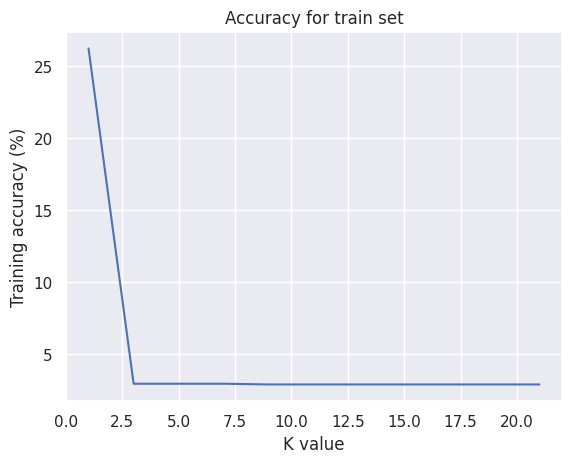

In [68]:
plt.plot(df_result['K value'], df_result['train pred'])
plt.xlabel('K value')
plt.ylabel('Training accuracy (%)')
plt.title('Accuracy for train set')
plt.show()

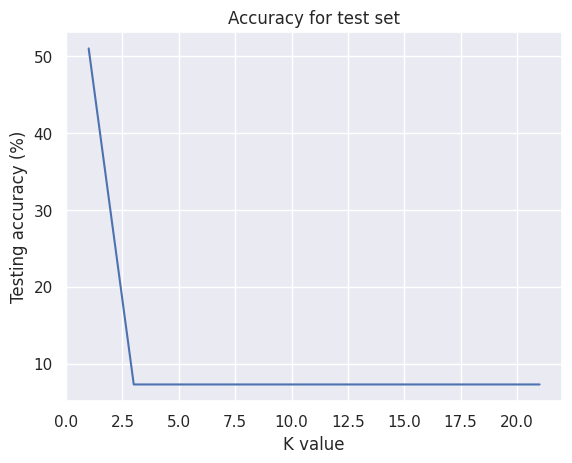

In [69]:
plt.plot(df_result['K value'], df_result['test pred'])
plt.xlabel('K value')
plt.ylabel('Testing accuracy (%)')
plt.title('Accuracy for test set')
plt.show()

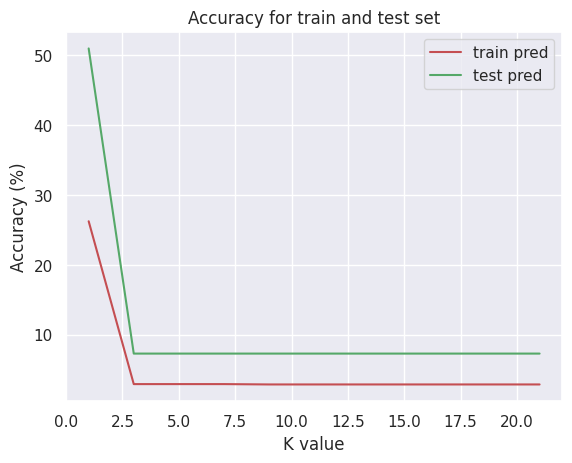

In [70]:
plt.plot(df_result['K value'], df_result['train pred'], 'r', label = 'train pred')
plt.plot(df_result['K value'], df_result['test pred'], 'g', label = 'test pred')
plt.legend(loc='upper right')
plt.xlabel('K value')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for train and test set')
plt.show()

In [71]:
(X_train, y_train) = load_data(ml_algo="K-Nearest-Neighbors")

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print("")
print("Total Counts of Defects and Non-Defects in dataset")
print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

# Data Augmentation
smote_augmentation = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote_augmentation.fit_resample(X_train, y_train)

X_train shape (2331, 630)
y_train shape (2331,)

Total Counts of Defects and Non-Defects in dataset
True count: 2085
False count: 246
Total counts: 2331


In [72]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_smote, y_train_smote)

KNeighborsClassifier(n_neighbors=3)

In [73]:
y_pred = knn.predict(X_test)

In [74]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1_score)

Test Accuracy: 0.8850771869639794
Test Precision: 0.8850771869639794
Test Recall: 1.0
Test F1 Score: 0.9390354868061875


### 5. Naive Bayes Classifier

#### No Data Augmentation

In [75]:
(X_train, y_train) = load_data(ml_algo="Naive-Bayes")

count_true = 0
count_false = 0

for t in Y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")


True count: 1555
False count: 193
Total counts: 1748


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 524
False count: 59
Total counts: 583


In [77]:
model = GaussianNB()

In [78]:
estimator = model.fit(X_train, y_train)

In [79]:
y_pred = model.predict(X_test)

In [80]:
print(sklearn_metrics.accuracy_score(y_test, y_pred)*100)

26.243567753001717


In [81]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", recall)

Test Accuracy: 0.2624356775300172
Test Precision: 0.9051724137931034
Test Recall: 0.20038167938931298
Test F1 Score: 0.20038167938931298


#### Data Augmentation

In [82]:
(X_train, y_train) = load_data(ml_algo="Naive-Bayes")

count_true = 0
count_false = 0

for t in Y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")


True count: 1555
False count: 193
Total counts: 1748


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 515
False count: 68
Total counts: 583


In [84]:
# Data Augmentation
smote_augmentation = SMOTE(sampling_strategy="auto", random_state=42)

X_train_smote, Y_train_smote = smote_augmentation.fit_resample(X_train, y_train)

In [85]:
print("X_train_smote.shape:", X_train_smote.shape)
print("Y_train_smote.shape:", Y_train_smote.shape)

X_train_smote.shape: (3140, 630)
Y_train_smote.shape: (3140,)


In [86]:
count_true = 0
count_false = 0

for t in Y_train_smote:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 1570
False count: 1570
Total counts: 3140


In [87]:
model = GaussianNB()

In [88]:
estimator = model.fit(X_train_smote, Y_train_smote)

In [89]:
y_pred = model.predict(X_test)

In [90]:
print(sklearn_metrics.accuracy_score(y_test, y_pred)*100)

34.133790737564325


In [91]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", recall)

Test Accuracy: 0.34133790737564323
Test Precision: 0.9225806451612903
Test Recall: 0.27766990291262134
Test F1 Score: 0.27766990291262134


### 6. Support Vector Machines

#### No Data Augmentation

In [ ]:
#(X_train, y_train) = load_data(ml_algo="Naive-Bayes")
(X_train, y_train) = load_data(ml_algo="SVM")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

In [ ]:
# Running the model
model = SVC()
estimator = model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
rf_accuracy = print(sklearn_metrics.accuracy_score(y_test, y_pred)*100)
train_accuracy = print(sklearn_metrics.accuracy_score(y_train, y_pred_train)*100)

In [ ]:
# Display confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVM')
plt.show()

In [ ]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", recall)

#### Data Augmentation

In [91]:
#(X_train, y_train) = load_data(ml_algo="Naive-Bayes")
(X_train, y_train) = load_data(ml_algo="SVM")

count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

In [ ]:
# Data Augmentation
smote_augmentation = SMOTE(sampling_strategy="auto", random_state=42)

X_train_smote, Y_train_smote = smote_augmentation.fit_resample(X_train, y_train)

In [ ]:
print("X_train_smote.shape:", X_train_smote.shape)
print("Y_train_smote.shape:", Y_train_smote.shape)

In [ ]:
count_true = 0
count_false = 0

for t in Y_train_smote:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

In [ ]:
model = SVC()
estimator = model.fit(X_train_smote, Y_train_smote)

In [ ]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
test_accuracy = print(sklearn_metrics.accuracy_score(y_test, y_pred)*100)
train_accuracy = print(sklearn_metrics.accuracy_score(y_train, y_pred_train)*100)

In [ ]:
# Display confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVM')
plt.show()

In [ ]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", recall)

### 7. Gradient Boosting Classifier

#### No Data Augmentation

In [92]:
(X_train, y_train) = load_data(ml_algo="Gradient-Boosting")

print(f"X_train shape {X_train.shape}")
print(f"Y_train shape {y_train.shape}")

X_train shape (2331, 630)
Y_train shape (2331,)


In [93]:
count_true = 0
count_false = 0

for t in Y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 1555
False count: 193
Total counts: 1748


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

In [95]:
count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 524
False count: 59
Total counts: 583


In [96]:
gb_no_augmentation = GradientBoostingClassifier(n_estimators = 100, max_features = 5, learning_rate = 0.1)

gb_no_augmentation.fit(X_train, y_train)

print('Training score: {:.3f}'.format(gb_no_augmentation.score(X_train, y_train)))
print('Test score : {:.3f}'.format(gb_no_augmentation.score(X_test, y_test)))

Training score: 0.900
Test score : 0.895


In [97]:
# Optimizing model parameters

gb_no_augmentation = GradientBoostingClassifier().fit(X_train, y_train)

param_values = {'n_estimators' : [10,50,100], 'max_features' : [5,10,20], 'learning_rate': [0.001, 0.01, 0.1]}
gs_no_augmentation = GridSearchCV(gb_no_augmentation, param_grid = param_values, cv = 5, scoring = 'accuracy')

gs_no_augmentation.fit(X_test, y_test)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_features': [5, 10, 20],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy')

In [98]:
y_pred = gb_no_augmentation.predict(X_test)

In [99]:
accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", recall)

Test Accuracy: 0.8833619210977701
Test Precision: 0.8986013986013986
Test Recall: 0.9809160305343512
Test F1 Score: 0.9809160305343512


#### Data Augmentation

In [100]:
(X_train, y_train) = load_data(ml_algo="Gradient-Boosting")

print(f"X_train shape {X_train.shape}")
print(f"Y_train shape {y_train.shape}")

X_train shape (2331, 630)
Y_train shape (2331,)


In [101]:
# Data Augmentation
smote_augmentation = SMOTE(sampling_strategy="auto", random_state=42)

X_train_smote, Y_train_smote = smote_augmentation.fit_resample(X_train, y_train)

In [102]:
print("X_train_smote.shape:", X_train_smote.shape)
print("Y_train_smote.shape:", Y_train_smote.shape)

X_train_smote.shape: (4170, 630)
Y_train_smote.shape: (4170,)


In [103]:
count_true = 0
count_false = 0

for t in Y_train_smote:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 2085
False count: 2085
Total counts: 4170


In [104]:
gb_with_augmentation = GradientBoostingClassifier(n_estimators = 100, max_features = 5, learning_rate = 0.1)

gb_with_augmentation.fit(X_train_smote, Y_train_smote)

print('Training score: {:.3f}'.format(gb_with_augmentation.score(X_train_smote, Y_train_smote)))
print('Test score : {:.3f}'.format(gb_with_augmentation.score(X_test, y_test)))

Training score: 0.597
Test score : 0.899


In [105]:
# Optimizing model parameters

gb_with_augmentation = GradientBoostingClassifier().fit(X_train_smote, Y_train_smote)

param_values = {'n_estimators' : [10,50,100], 'max_features' : [5,10,20], 'learning_rate': [0.001, 0.01, 0.1]}
gs_with_augmentation = GridSearchCV(gb_with_augmentation, param_grid = param_values, cv = 5, scoring = 'accuracy')

gs_with_augmentation.fit(X_test, y_test)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_features': [5, 10, 20],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy')

In [106]:
y_pred = gb_with_augmentation.predict(X_test)

accuracy = sklearn_metrics.accuracy_score(y_test, y_pred)
precision = sklearn_metrics.precision_score(y_test, y_pred)
recall = sklearn_metrics.recall_score(y_test, y_pred)
f1_score = sklearn_metrics.f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", recall)

Test Accuracy: 0.9039451114922813
Test Precision: 0.903448275862069
Test Recall: 1.0
Test F1 Score: 1.0


### 7. Convolutional Neural Networks

#### No Data Augmentation

In [107]:
# generate images and labels
images_mini, y_mini = load_data(ml_algo="cnn")

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (2331, 224, 224, 3)
y_mini shape (2331,)


In [108]:
count_true = 0
count_false = 0

for t in y_mini:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 2085
False count: 246
Total counts: 2331


In [109]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])

    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

In [110]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1398, 224, 224, 3)
y_train shape (1398,)
X_val shape (466, 224, 224, 3)
y_val shape (466,)
X_test shape (467, 224, 224, 3)
y_test shape (467,)


In [111]:
count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

print("")

count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 1248
False count: 150
Total counts: 1398

True count: 422
False count: 45
Total counts: 467


In [112]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1',
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 64)      51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 56, 56, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              205521920 
                                                                 
 dropout (Dropout)           (None, 1024)             

In [113]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=[keras_metrics.binary_accuracy,
                       keras_metrics.Precision(),
                       keras_metrics.Recall(),
                       keras_metrics.AUC(),
                       keras_metrics.F1Score(threshold=0.5)])

In [114]:
# set random seed to get reproductible results
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    validation_data=(X_val, y_val)
)

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history_epochs = pd.DataFrame(history.history)
display(history_epochs)

Epoch 1/10
44/44 [==============================] - 9s 51ms/step - loss: 0.3850 - binary_accuracy: 0.8569 - precision_1: 0.8928 - recall_1: 0.9543 - auc_1: 0.5076 - f1_score: 0.9225 - val_loss: 0.3700 - val_binary_accuracy: 0.8906 - val_precision_1: 0.8906 - val_recall_1: 1.0000 - val_auc_1: 0.5000 - val_f1_score: 0.9421
Epoch 2/10
44/44 [==============================] - 1s 24ms/step - loss: 0.3829 - binary_accuracy: 0.8927 - precision_1: 0.8927 - recall_1: 1.0000 - auc_1: 0.4934 - f1_score: 0.9433 - val_loss: 0.3532 - val_binary_accuracy: 0.8906 - val_precision_1: 0.8906 - val_recall_1: 1.0000 - val_auc_1: 0.5000 - val_f1_score: 0.9421
Epoch 3/10
44/44 [==============================] - 1s 24ms/step - loss: 0.3534 - binary_accuracy: 0.8927 - precision_1: 0.8927 - recall_1: 1.0000 - auc_1: 0.5109 - f1_score: 0.9433 - val_loss: 0.3513 - val_binary_accuracy: 0.8906 - val_precision_1: 0.8906 - val_recall_1: 1.0000 - val_auc_1: 0.5000 - val_f1_score: 0.9421
Epoch 4/10
44/44 [=============

,loss,binary_accuracy,precision_1,recall_1,auc_1,f1_score,val_loss,val_binary_accuracy,val_precision_1,val_recall_1,val_auc_1,val_f1_score
0,0.385026,0.856938,0.892804,0.954327,0.507650,[0.92254066],0.370026,0.890558,0.890558,1.0,0.5,[0.9421112]
1,0.382863,0.892704,0.892704,1.000000,0.493360,[0.9433107],0.353217,0.890558,0.890558,1.0,0.5,[0.9421112]
2,0.353415,0.892704,0.892704,1.000000,0.510857,[0.9433107],0.351285,0.890558,0.890558,1.0,0.5,[0.9421112]
3,0.360401,0.892704,0.892704,1.000000,0.500000,[0.9433107],0.346359,0.890558,0.890558,1.0,0.5,[0.9421112]
4,0.351687,0.892704,0.892704,1.000000,0.505200,[0.9433107],0.355030,0.890558,0.890558,1.0,0.5,[0.9421112]
5,0.345415,0.892704,0.892704,1.000000,0.500000,[0.9433107],0.360049,0.890558,0.890558,1.0,0.5,[0.9421112]
6,0.361824,0.892704,0.892704,1.000000,0.499706,[0.9433107],0.346824,0.890558,0.890558,1.0,0.5,[0.9421112]
7,0.343902,0.892704,0.892704,1.000000,0.499599,[0.9433107],0.345233,0.890558,0.890558,1.0,0.5,[0.9421112]
8,0.354286,0.892704,0.892704,1.000000,0.499199,[0.9433107],0.354322,0.890558,0.890558,1.0,0.5,[0.9421112]
9,0.345380,0.892704,0.892704,1.000000,0.500000,[0.9433107],0.354743,0.890558,0.890558,1.0,0.5,[0.9421112]


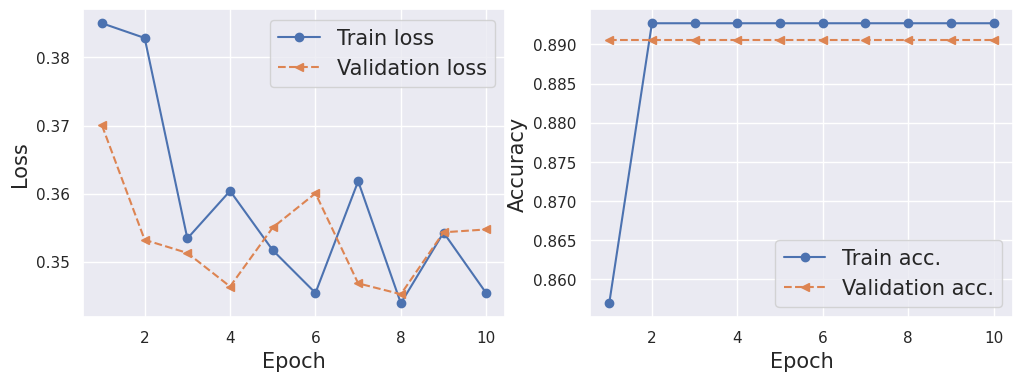

In [115]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['binary_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_binary_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [116]:
test_results = model.evaluate(X_test, y_test)
print('\nTest set accuracy {:.2f}%'.format(test_results[1]*100))

15/15 [==============================] - 0s 18ms/step - loss: 0.3329 - binary_accuracy: 0.9036 - precision_1: 0.9036 - recall_1: 1.0000 - auc_1: 0.5000 - f1_score: 0.9494

Test set accuracy 90.36%


#### Data Augmentation

In [224]:
# generate images and labels
images_mini, y_mini = load_data(ml_algo="cnn")

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (2331, 224, 224, 3)
y_mini shape (2331,)


In [225]:
count_true = 0
count_false = 0

for t in y_mini:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 2085
False count: 246
Total counts: 2331


In [226]:
IMAGE_SIZE = (224, 224)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])

    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)

    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0


    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)

    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)

    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

In [227]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (2796, 224, 224, 3)
y_train shape (2796,)
X_val shape (466, 224, 224, 3)
y_val shape (466,)
X_test shape (467, 224, 224, 3)
y_test shape (467,)


In [228]:
count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

print("")

count_true = 0
count_false = 0

for t in y_test:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 2496
False count: 300
Total counts: 2796

True count: 422
False count: 45
Total counts: 467


In [229]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1',
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 64)      51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 56, 56, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              205521920 
                                                                 
 dropout (Dropout)           (None, 1024)             

In [230]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=[keras_metrics.binary_accuracy,
                       keras_metrics.Precision(),
                       keras_metrics.Recall(),
                       keras_metrics.AUC(),
                       keras_metrics.F1Score(threshold=0.5)])

In [231]:
# set random seed to get reproductible results
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    validation_data=(X_val, y_val)
)


# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history_epochs = pd.DataFrame(history.history)
display(history_epochs)

Epoch 1/10
88/88 [==============================] - 4s 27ms/step - loss: 0.4756 - binary_accuracy: 0.8737 - precision_1: 0.8938 - recall_1: 0.9744 - auc_1: 0.5188 - f1_score: 0.9323 - val_loss: 0.3549 - val_binary_accuracy: 0.8906 - val_precision_1: 0.8906 - val_recall_1: 1.0000 - val_auc_1: 0.5000 - val_f1_score: 0.9421
Epoch 2/10
88/88 [==============================] - 2s 22ms/step - loss: 0.3595 - binary_accuracy: 0.8920 - precision_1: 0.8926 - recall_1: 0.9992 - auc_1: 0.4963 - f1_score: 0.9429 - val_loss: 0.3676 - val_binary_accuracy: 0.8906 - val_precision_1: 0.8906 - val_recall_1: 1.0000 - val_auc_1: 0.5000 - val_f1_score: 0.9421
Epoch 3/10
88/88 [==============================] - 2s 22ms/step - loss: 0.3624 - binary_accuracy: 0.8927 - precision_1: 0.8927 - recall_1: 1.0000 - auc_1: 0.5006 - f1_score: 0.9433 - val_loss: 0.3555 - val_binary_accuracy: 0.8906 - val_precision_1: 0.8906 - val_recall_1: 1.0000 - val_auc_1: 0.5000 - val_f1_score: 0.9421
Epoch 4/10
88/88 [=============

,loss,binary_accuracy,precision_1,recall_1,auc_1,f1_score,val_loss,val_binary_accuracy,val_precision_1,val_recall_1,val_auc_1,val_f1_score
0,0.475627,0.873748,0.893789,0.974359,0.518754,[0.93233657],0.354861,0.890558,0.890558,1.0,0.5,[0.9421112]
1,0.359506,0.891989,0.892627,0.999199,0.496314,[0.94291115],0.367625,0.890558,0.890558,1.0,0.5,[0.9421112]
2,0.362373,0.892704,0.892704,1.000000,0.500644,[0.9433107],0.355472,0.890558,0.890558,1.0,0.5,[0.9421112]
3,0.361840,0.892704,0.892704,1.000000,0.508492,[0.9433107],0.344753,0.890558,0.890558,1.0,0.5,[0.9421112]
4,0.362543,0.892346,0.892665,0.999599,0.497167,[0.94311094],0.370151,0.890558,0.890558,1.0,0.5,[0.9421112]
5,0.354146,0.892704,0.892704,1.000000,0.499781,[0.9433107],0.379380,0.890558,0.890558,1.0,0.5,[0.9421112]
6,0.357065,0.892346,0.892665,0.999599,0.498983,[0.94311094],0.346008,0.890558,0.890558,1.0,0.5,[0.9421112]
7,0.360586,0.892346,0.892665,0.999599,0.500098,[0.94311094],0.361068,0.890558,0.890558,1.0,0.5,[0.9421112]
8,0.353996,0.891989,0.892627,0.999199,0.502010,[0.94291115],0.375367,0.890558,0.890558,1.0,0.5,[0.9421112]
9,0.357278,0.892346,0.892665,0.999599,0.497969,[0.94311094],0.345972,0.890558,0.890558,1.0,0.5,[0.9421112]


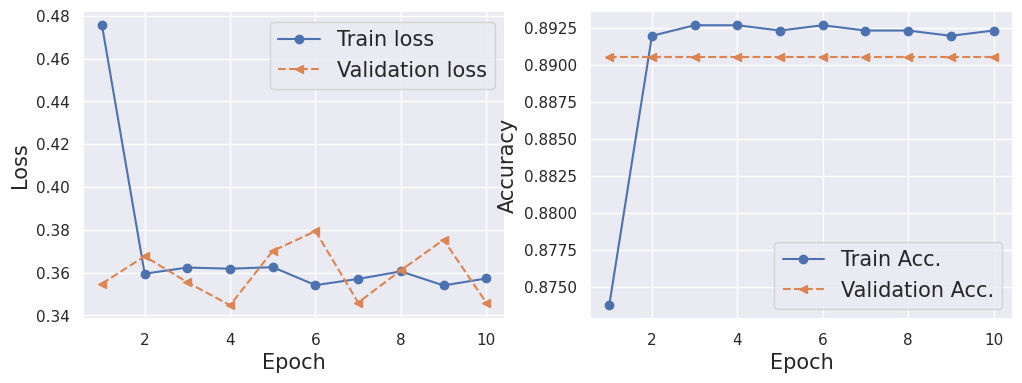

In [232]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['binary_accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_binary_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [233]:
test_results = model.evaluate(X_test, y_test)
print('\nTest set Accuracy. {:.2f}%'.format(test_results[1]*100))

15/15 [==============================] - 0s 10ms/step - loss: 0.3167 - binary_accuracy: 0.9036 - precision_1: 0.9036 - recall_1: 1.0000 - auc_1: 0.5000 - f1_score: 0.9494

Test set Accuracy. 90.36%


#### Experiments with Convolutional Neural Networks


| Training accuracy | Validation accuracy |  kernel size |  strides | pool size  |  learning rate | optimizer  | brightness (delta) |  contrast factor | flip_on_train  |
|:-:                |:-:                  |:-:           |:-:       |:-:         |:-:             |:-:         |:-:                 |:-:               |:-:             |
| 0.8963              | 0.8863                | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.8963              | 0.8863                 | <font color="red">3,3</font>     | 1,1      | 2,2        | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.8963               | 0.8863                 | 5,5          | <font color="red">2,2</font>  | 2,2        | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.8963               | 0.8863                 | 5,5          | 1,1      | <font color="red">3,3</font>   | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.8963             | 0.8863                 | 5,5          | 1,1      | 2,2        | <font color="red">0.01</font>       | Adam       | 0.3                | 3                | yes            |
| 0.8963               | 0.8863                 | 5,5          | 1,1      | 2,2        | 0.001          |<font color="red">SGD</font>     | 0.3                | 3                | yes            |

### 8. ResNet Transfer Learning

In [127]:
# generate images and labels
images_mini, y_mini = load_data(ml_algo="resnet")

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (2331, 224, 224, 3)
y_mini shape (2331,)


In [128]:
count_true = 0
count_false = 0

for t in y_mini:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 2085
False count: 246
Total counts: 2331


#### No Data Augmentation

In [129]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])

    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

In [130]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1398, 224, 224, 3)
y_train shape (1398,)
X_val shape (466, 224, 224, 3)
y_val shape (466,)
X_test shape (467, 224, 224, 3)
y_test shape (467,)


In [131]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3), classes=2)
for layer in resnet_50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [132]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='sigmoid')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [133]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [134]:
# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)



In [135]:
model_history = trainModel(model = model, epochs = 10, optimizer = "Adam")

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history_epochs = pd.DataFrame(model_history.history)
display(history_epochs)

Epoch 1/10
44/44 [==============================] - 8s 71ms/step - loss: 0.7046 - accuracy: 0.8255 - val_loss: 0.4523 - val_accuracy: 0.8906
Epoch 2/10
44/44 [==============================] - 1s 27ms/step - loss: 0.4492 - accuracy: 0.8777 - val_loss: 0.3722 - val_accuracy: 0.8906
Epoch 3/10
44/44 [==============================] - 1s 27ms/step - loss: 0.4308 - accuracy: 0.8898 - val_loss: 0.3549 - val_accuracy: 0.8906
Epoch 4/10
44/44 [==============================] - 1s 27ms/step - loss: 0.4155 - accuracy: 0.8891 - val_loss: 0.3919 - val_accuracy: 0.8906
Epoch 5/10
44/44 [==============================] - 1s 27ms/step - loss: 0.3910 - accuracy: 0.8934 - val_loss: 0.3537 - val_accuracy: 0.8906
Epoch 6/10
44/44 [==============================] - 1s 27ms/step - loss: 0.3988 - accuracy: 0.8927 - val_loss: 0.4242 - val_accuracy: 0.8906
Epoch 7/10
44/44 [==============================] - 1s 27ms/step - loss: 0.3798 - accuracy: 0.8927 - val_loss: 0.3746 - val_accuracy: 0.8906
Epoch 8/10
44

,loss,accuracy,val_loss,val_accuracy
0,0.704645,0.825465,0.452285,0.890558
1,0.449238,0.877682,0.372246,0.890558
2,0.430826,0.889843,0.354923,0.890558
3,0.415495,0.889127,0.391906,0.890558
4,0.391006,0.893419,0.353729,0.890558
5,0.398825,0.892704,0.424178,0.890558
6,0.379780,0.892704,0.374554,0.890558
7,0.378480,0.892704,0.401504,0.890558
8,0.379814,0.891989,0.388912,0.890558
9,0.371901,0.892704,0.425412,0.890558


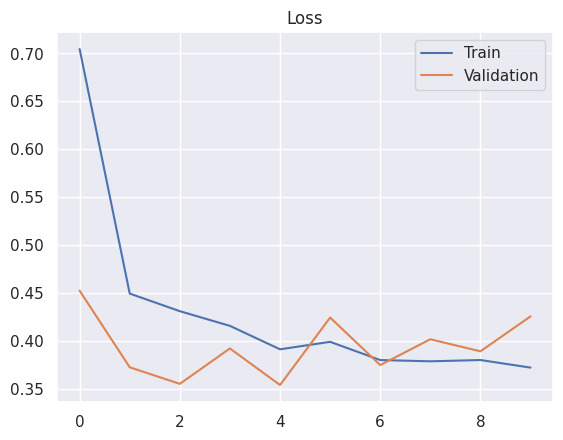

In [136]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

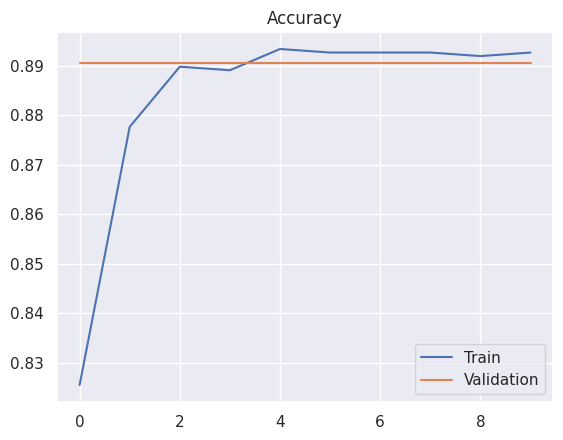

In [137]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [138]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("The test loss is: ", test_loss)
print("The best test accuracy is: ", test_acc*100)

15/15 [==============================] - 1s 38ms/step - loss: 0.4123 - accuracy: 0.9036
The test loss is:  0.41231629252433777
The best test accuracy is:  90.36402702331543


#### Data Augmentation

In [139]:
# generate images and labels
images_mini, y_mini = load_data(ml_algo="resnet")

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (2331, 224, 224, 3)
y_mini shape (2331,)


In [140]:
count_true = 0
count_false = 0

for t in y_mini:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 2085
False count: 246
Total counts: 2331


In [141]:
IMAGE_SIZE = (224, 224)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])

    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)

    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0


    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)

    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    # X_train_augm = tf.image.random_flip_left_right(X_train_augm)

    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

In [142]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (2796, 224, 224, 3)
y_train shape (2796,)
X_val shape (466, 224, 224, 3)
y_val shape (466,)
X_test shape (467, 224, 224, 3)
y_test shape (467,)


In [143]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3), classes=2)
for layer in resnet_50.layers:
    layer.trainable = False

In [144]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='sigmoid')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [145]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [146]:
# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

In [147]:
model_history = trainModel(model = model, epochs = 10, optimizer = "Adam")

print("")
# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history_epochs = pd.DataFrame(model_history.history)
display(history_epochs)

Epoch 1/10
88/88 [==============================] - 8s 39ms/step - loss: 0.6145 - accuracy: 0.8247 - val_loss: 0.3859 - val_accuracy: 0.8906
Epoch 2/10
88/88 [==============================] - 2s 23ms/step - loss: 0.4220 - accuracy: 0.8852 - val_loss: 0.3959 - val_accuracy: 0.8906
Epoch 3/10
88/88 [==============================] - 2s 23ms/step - loss: 0.3925 - accuracy: 0.8902 - val_loss: 0.3783 - val_accuracy: 0.8906
Epoch 4/10
88/88 [==============================] - 2s 24ms/step - loss: 0.3795 - accuracy: 0.8916 - val_loss: 0.3558 - val_accuracy: 0.8906
Epoch 5/10
88/88 [==============================] - 2s 24ms/step - loss: 0.3766 - accuracy: 0.8923 - val_loss: 0.3809 - val_accuracy: 0.8906
Epoch 6/10
88/88 [==============================] - 2s 23ms/step - loss: 0.3752 - accuracy: 0.8927 - val_loss: 0.3870 - val_accuracy: 0.8906
Epoch 7/10
88/88 [==============================] - 2s 23ms/step - loss: 0.3710 - accuracy: 0.8927 - val_loss: 0.3642 - val_accuracy: 0.8906
Epoch 8/10
88

,loss,accuracy,val_loss,val_accuracy
0,0.614466,0.824750,0.385867,0.890558
1,0.422040,0.885193,0.395917,0.890558
2,0.392534,0.890200,0.378345,0.890558
3,0.379545,0.891631,0.355797,0.890558
4,0.376617,0.892346,0.380921,0.890558
5,0.375229,0.892704,0.387019,0.890558
6,0.370954,0.892704,0.364167,0.890558
7,0.368455,0.892704,0.364026,0.890558
8,0.368675,0.892346,0.376770,0.890558
9,0.367275,0.892704,0.369918,0.890558


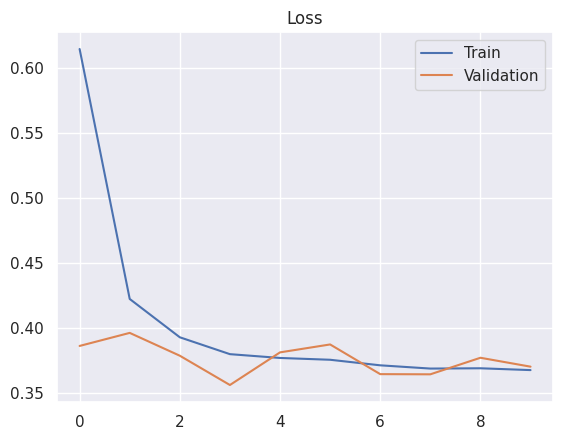

In [148]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

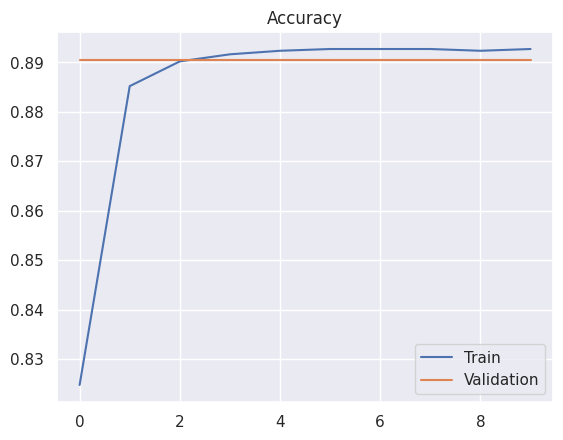

In [149]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [150]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

15/15 [==============================] - 0s 19ms/step - loss: 0.3510 - accuracy: 0.9036
The test loss is:  0.3509969711303711
The best accuracy is:  90.36402702331543


### 9. Xception Transfer Learning

#### No Data Augmentation

In [151]:
# generate images and labels
images_mini, y_mini = load_data(ml_algo="xception")

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (2331, 299, 299, 3)
y_mini shape (2331,)


In [152]:
count_true = 0
count_false = 0

for t in y_mini:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 2085
False count: 246
Total counts: 2331


In [153]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])

    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

In [154]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1398, 299, 299, 3)
y_train shape (1398,)
X_val shape (466, 299, 299, 3)
y_val shape (466,)
X_test shape (467, 299, 299, 3)
y_test shape (467,)


In [155]:
count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 1248
False count: 150
Total counts: 1398


In [156]:
model = Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="sigmoid",
)

In [157]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              #loss="binary_crossentropy",
              metrics=['accuracy'])

In [158]:
print(model.summary())

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [159]:
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_val, y_val))

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history_epochs = pd.DataFrame(history.history)
display(history_epochs)

Epoch 1/5
44/44 [==============================] - 37s 215ms/step - loss: 0.3602 - accuracy: 0.8813 - val_loss: 0.6003 - val_accuracy: 0.8906
Epoch 2/5
44/44 [==============================] - 6s 129ms/step - loss: 0.2502 - accuracy: 0.9220 - val_loss: 0.4472 - val_accuracy: 0.8906
Epoch 3/5
44/44 [==============================] - 6s 129ms/step - loss: 0.2180 - accuracy: 0.9306 - val_loss: 0.3611 - val_accuracy: 0.8906
Epoch 4/5
44/44 [==============================] - 6s 129ms/step - loss: 0.2312 - accuracy: 0.9335 - val_loss: 0.3522 - val_accuracy: 0.8906
Epoch 5/5
44/44 [==============================] - 6s 130ms/step - loss: 0.2451 - accuracy: 0.9263 - val_loss: 0.3556 - val_accuracy: 0.8906


,loss,accuracy,val_loss,val_accuracy
0,0.360241,0.881259,0.600315,0.890558
1,0.250175,0.922031,0.447249,0.890558
2,0.218011,0.930615,0.361084,0.890558
3,0.231176,0.933476,0.352183,0.890558
4,0.245149,0.926323,0.355640,0.890558


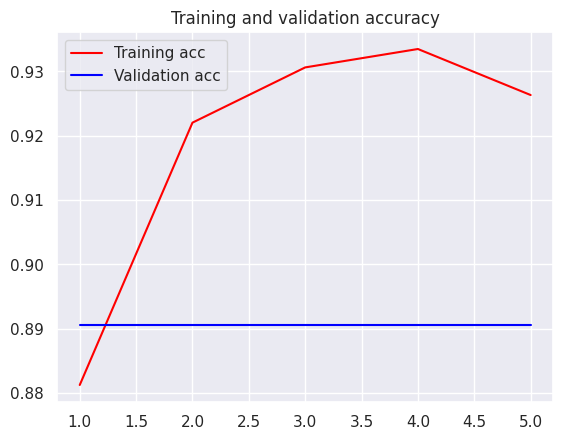

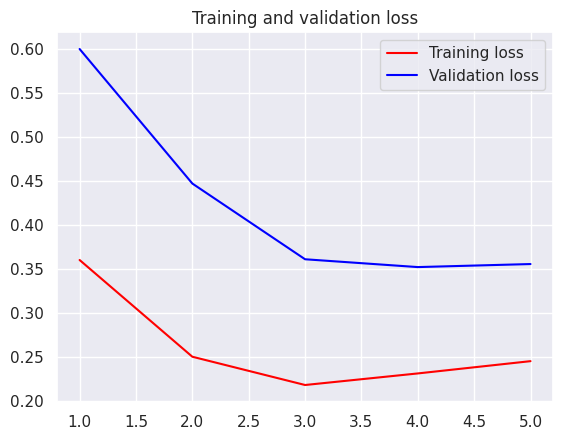

In [160]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [161]:
test_results = model.evaluate(X_test, y_test)
print('\nTest set Accuracy. {:.2f}%'.format(test_results[1]*100))

15/15 [==============================] - 1s 46ms/step - loss: 0.3218 - accuracy: 0.9036

Test set Accuracy. 90.36%


#### Data Augmentation

In [173]:
# generate images and labels
images_mini, y_mini = load_data(ml_algo="xception")

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (2331, 299, 299, 3)
y_mini shape (2331,)


In [174]:
count_true = 0
count_false = 0

for t in y_mini:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 2085
False count: 246
Total counts: 2331


In [175]:
IMAGE_SIZE = (299, 299)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])

    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)

    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0


    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)

    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)

    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

In [176]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (2796, 299, 299, 3)
y_train shape (2796,)
X_val shape (466, 299, 299, 3)
y_val shape (466,)
X_test shape (467, 299, 299, 3)
y_test shape (467,)


In [177]:
count_true = 0
count_false = 0

for t in y_train:
    if t == 0:
        count_false += 1
    elif t == 1:
        count_true += 1

print(f"True count: {count_true}")
print(f"False count: {count_false}")
print(f"Total counts: {count_true + count_false}")

True count: 2496
False count: 300
Total counts: 2796


In [178]:
model = Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="sigmoid",
)

In [179]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [180]:
print(model.summary())

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_5[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [181]:
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_val, y_val))

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history_epochs = pd.DataFrame(history.history)
display(history_epochs)

Epoch 1/5
88/88 [==============================] - 37s 135ms/step - loss: 0.4241 - accuracy: 0.8734 - val_loss: 0.6076 - val_accuracy: 0.8906
Epoch 2/5
88/88 [==============================] - 11s 124ms/step - loss: 0.3550 - accuracy: 0.8927 - val_loss: 0.5402 - val_accuracy: 0.8906
Epoch 3/5
88/88 [==============================] - 11s 124ms/step - loss: 0.3527 - accuracy: 0.8927 - val_loss: 0.4937 - val_accuracy: 0.8906
Epoch 4/5
88/88 [==============================] - 11s 124ms/step - loss: 0.3565 - accuracy: 0.8909 - val_loss: 0.4562 - val_accuracy: 0.8906
Epoch 5/5
88/88 [==============================] - 11s 124ms/step - loss: 0.3514 - accuracy: 0.8927 - val_loss: 0.3821 - val_accuracy: 0.8906


,loss,accuracy,val_loss,val_accuracy
0,0.424110,0.873391,0.607631,0.890558
1,0.354975,0.892704,0.540171,0.890558
2,0.352686,0.892704,0.493701,0.890558
3,0.356487,0.890916,0.456157,0.890558
4,0.351356,0.892704,0.382081,0.890558


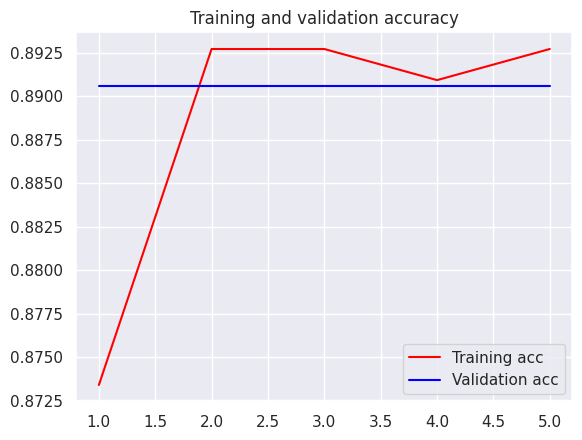

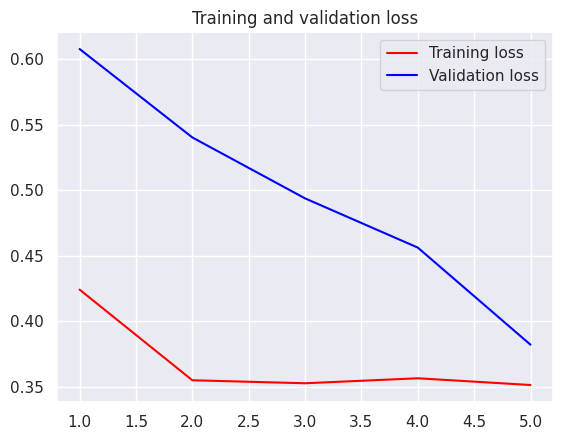

In [184]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [183]:
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

15/15 [==============================] - 1s 32ms/step - loss: 0.3649 - accuracy: 0.9036

Test Acc. 90.36%
